# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *
from batina_guess_number import *

## Visualize HW Behavior

In [2]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [3]:
guess_range=(0.0, 5e0)
# the number of guess values in the guess range
guess_val_size=1000
# generate the known inputs which is used to test the guess values
input_range = 2
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 1.908264
print('secret_number =', secret_number)

secret_number = 1.908264


In [4]:
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

3.815    0.329042
1.910    0.292322
1.905    0.257922
1.900    0.253789
0.955    0.243420
3.820    0.240403
1.920    0.235138
3.805    0.229980
0.950    0.214557
3.810    0.213171
dtype: float64

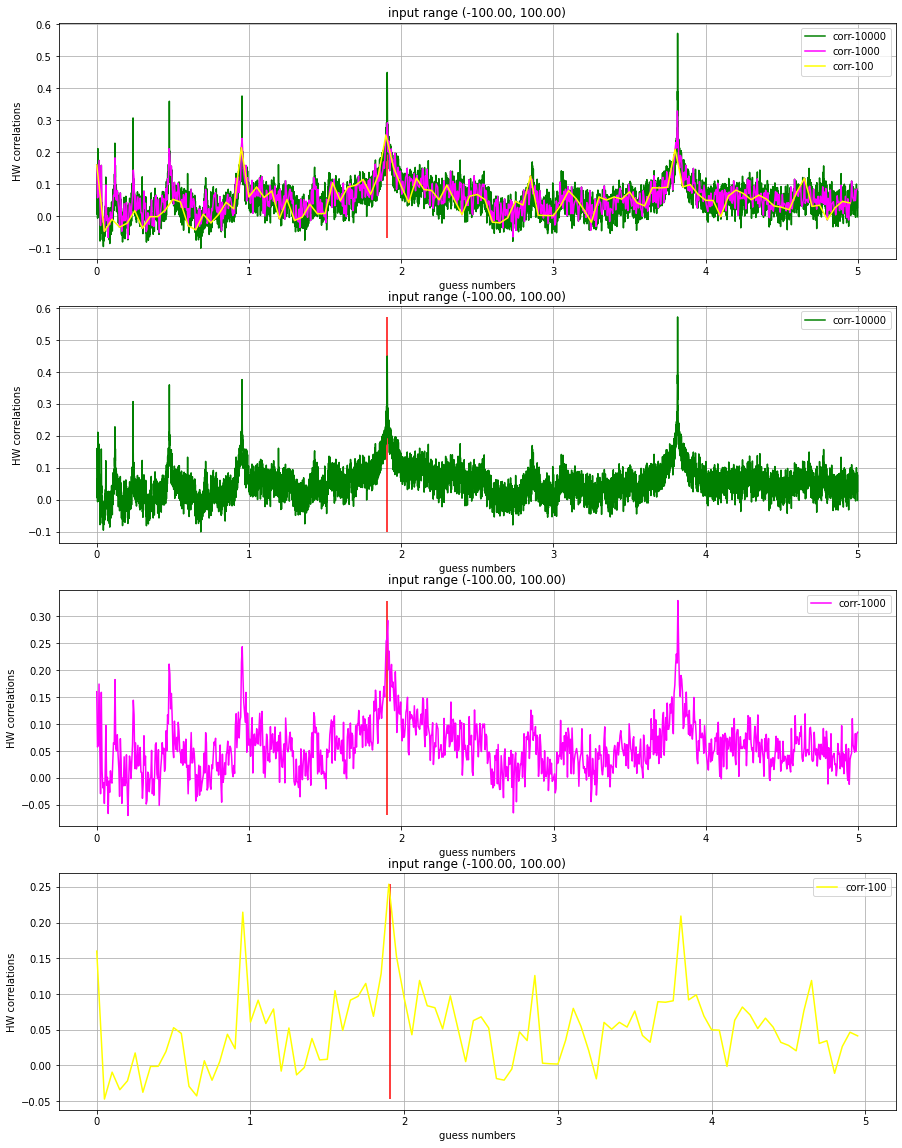

In [5]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantissa

In [6]:
guess_numbers = build_guess_values(value_type='mantissa', mantissa_nbits=12, guess_range=guess_range)
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

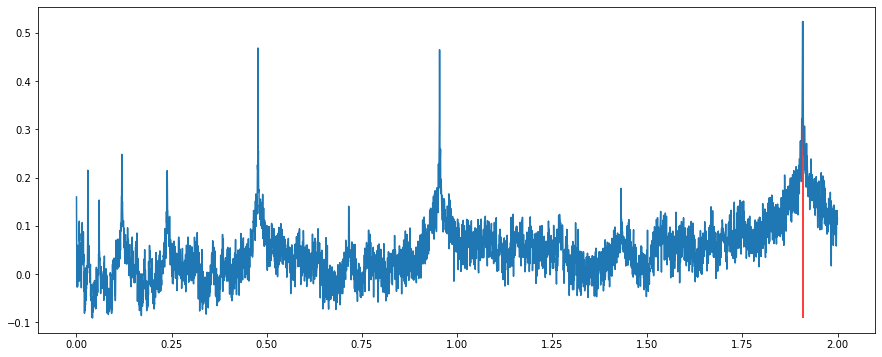

In [7]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [8]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.908203    0.523597
0.477051    0.468546
0.954102    0.464864
1.907715    0.408453
1.907227    0.375929
1.908691    0.364218
1.909180    0.361563
1.909668    0.342209
1.905762    0.321995
0.953613    0.321863
dtype: float64

## Correlation exponent

In [9]:
guess_numbers = build_guess_values(value_type='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

lo_range = 0.000000, hi_range=5.000000


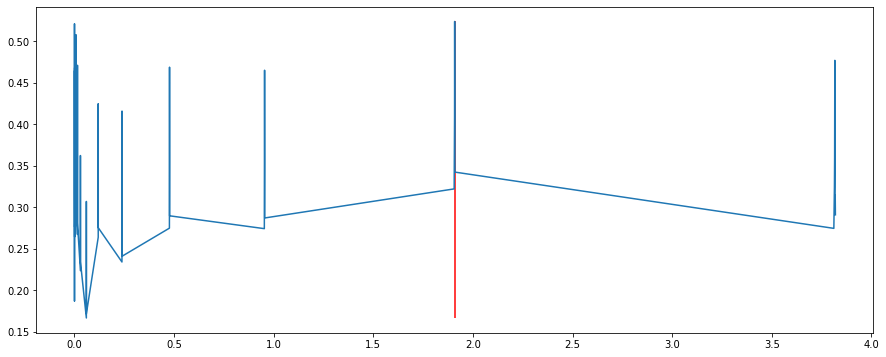

In [10]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [11]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

1.908203e+00    0.523597
1.908203e+00    0.523597
1.908203e+00    0.523597
1.034439e-19    0.520803
1.034439e-19    0.520803
1.034439e-19    0.520803
2.408491e-29    0.517211
4.442882e-10    0.517211
2.408491e-29    0.517211
4.442882e-10    0.517211
dtype: float64

## Correlation sign

In [12]:
guess_numbers = build_guess_values(value_type='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

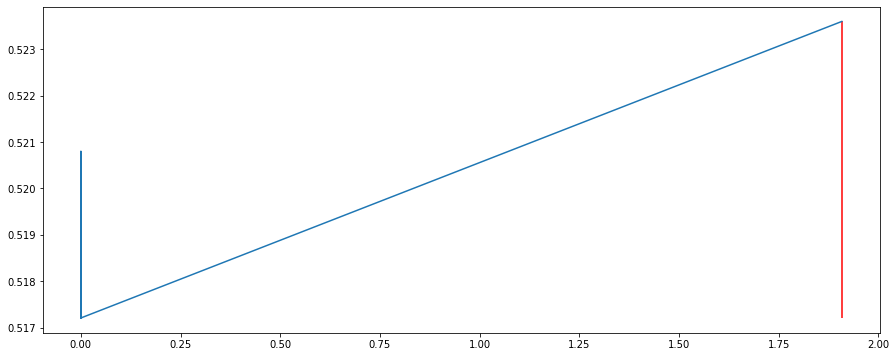

In [13]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [14]:
full_number_corr.sort_values(ascending=False).iloc[:10]

1.908203e+00    0.523597
1.908203e+00    0.523597
1.908203e+00    0.523597
1.034439e-19    0.520803
1.034439e-19    0.520803
1.034439e-19    0.520803
4.442882e-10    0.517211
2.408491e-29    0.517211
4.442882e-10    0.517211
2.408491e-29    0.517211
dtype: float64

## Recover a secret number

lo_range = 0.000000, hi_range=5.000000


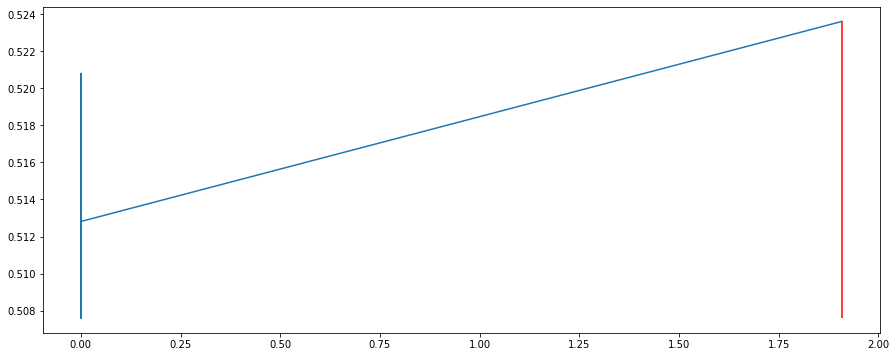

In [15]:
full_number_corr = batina_recover_weight(weight_hw=secret_hw, known_inputs=known_inputs, guess_range=guess_range)
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [16]:
full_number_corr.sort_values(ascending=False).iloc[:10]

1.908203e+00    0.523597
1.034439e-19    0.520803
2.408491e-29    0.517211
4.442882e-10    0.517211
1.578429e-24    0.512813
6.779299e-15    0.512813
3.675066e-34    0.512813
2.911687e-05    0.512813
1.435572e-36    0.507610
2.648164e-17    0.507610
dtype: float64

## Analyze with noise - one number

In [17]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [18]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [19]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

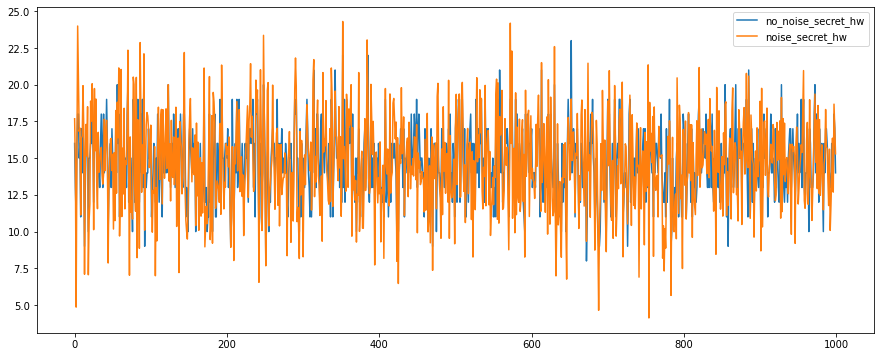

In [20]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=200)
ax = pd.DataFrame([no_noise_secret_hw, noise_secret_hw], index=['no_noise_secret_hw', 'noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [21]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 1.908264


3.815    0.248714
1.910    0.192071
3.805    0.177814
1.920    0.174290
1.905    0.170703
0.955    0.165901
3.820    0.162069
1.900    0.158106
3.835    0.156139
1.935    0.153500
dtype: float64

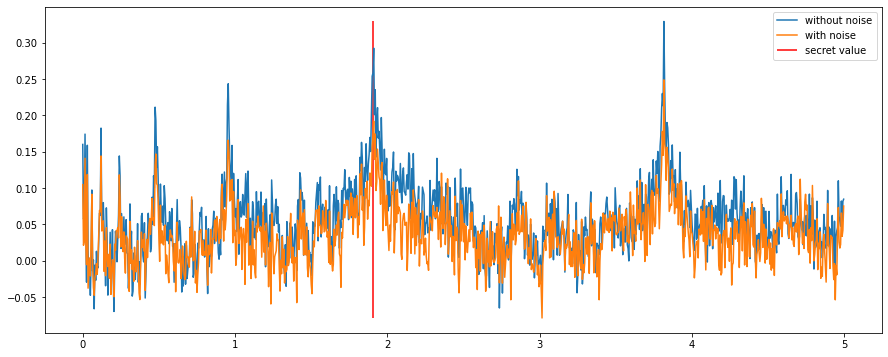

In [22]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [23]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 1000
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (1000,)


In [24]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [25]:
secret_numbers_hws[0]

,0.316591,1.043426,0.462676,2.060739,0.189507,2.701784,0.252733,0.453589,0.859690,2.646988,...,1.282903,0.546624,0.208730,3.916364,0.534479,0.312633,0.299646,0.375784,1.072573,0.657396
0,18,19,16,21,15,20,15,21,20,24,...,18,25,16,17,21,17,20,17,24,18
1,21,16,15,16,16,14,17,12,13,15,...,12,15,18,16,15,19,18,19,17,15
2,17,16,17,18,17,19,15,16,16,20,...,19,17,16,15,22,22,17,17,16,16
3,18,19,20,19,13,16,16,24,20,10,...,21,13,18,18,20,17,14,12,14,24
4,18,15,15,20,14,19,12,18,19,21,...,20,18,10,11,16,18,16,16,20,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,17,20,16,20,16,18,21,20,19,21,...,18,18,16,13,17,19,12,17,17,20
496,20,20,18,16,17,14,16,14,18,17,...,22,15,15,16,18,22,24,16,18,18
497,20,22,21,23,16,14,18,20,19,13,...,19,20,18,14,16,20,16,20,23,19
498,18,16,22,19,22,20,15,17,21,21,...,22,21,18,10,15,15,17,18,16,18


In [26]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [27]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[0.316591] -2 2.532728 2.532729 0.914993'
'[0.316591] -1 1.266364 1.266364 0.954230'
'[0.316591] 00 2.532728 2.532729 0.696650'
'[0.316591] 01 0.316591 0.316591 0.999013'
'[0.316591] 02 0.316591 0.316591 0.997822'
'[0.316591] 03 2.532728 2.532729 0.929491'
'[1.043426] -2 4.173704 4.173705 0.923699'
'[1.043426] -1 4.173704 4.173705 0.977591'
'[1.043426] 00 1.043426 1.043426 1.000000'
'[1.043426] 01 1.043426 1.043426 1.000000'
'[1.043426] 02 4.173704 4.173705 0.974383'
'[1.043426] 03 1.043426 1.043426 1.000000'
'[0.462676] -2 0.462676 0.462676 0.994466'
'[0.462676] -1 0.462676 0.462676 0.996670'
'[0.462676] 00 1.850703 1.850703 0.983810'
'[0.462676] 01 0.462676 0.462676 0.996538'
'[0.462676] 02 0.462676 0.462676 0.996713'
'[0.462676] 03 0.462676 0.462676 0.991123'
'[2.060739] -2 2.060739 2.060739 0.999010'
'[2.060739] -1 2.060739 2.060739 0.999073'
'[2.060739] 00 2.060739 2.060739 0.998761'
'[2.060739] 01 2.060739 2.060739 0.999879'
'[2.060739] 02 2.060739 2.060739 0.999836'
'[2.060739]

'[0.432421] 03 4.612489 4.612490 0.394116'
'[1.529182] -2 1.529182 1.529183 0.999847'
'[1.529182] -1 1.529182 1.529183 0.999855'
'[1.529182] 00 1.529182 1.529183 0.999830'
'[1.529182] 01 1.529182 1.529183 0.999043'
'[1.529182] 02 1.529182 1.529183 0.999673'
'[1.529182] 03 1.529182 1.529183 0.999841'
'[2.834575] -2 2.834575 2.834575 0.999841'
'[2.834575] -1 2.834575 2.834575 0.999853'
'[2.834575] 00 2.834575 2.834575 0.999860'
'[2.834575] 01 2.834575 2.834575 0.999861'
'[2.834575] 02 2.834575 2.834575 0.999337'
'[2.834575] 03 2.834575 2.834575 0.999371'
'[1.547139] -2 1.547139 1.547139 0.999553'
'[1.547139] -1 1.547139 1.547139 0.998661'
'[1.547139] 00 1.547139 1.547139 0.999850'
'[1.547139] 01 1.547139 1.547139 0.999412'
'[1.547139] 02 1.547139 1.547139 0.999829'
'[1.547139] 03 1.547139 1.547139 0.999840'
'[4.284726] -2 4.284725 4.284726 0.999845'
'[4.284726] -1 4.284725 4.284726 0.999251'
'[4.284726] 00 4.284725 4.284726 1.000000'
'[4.284726] 01 4.284725 4.284726 1.000000'
'[4.284726]

'[0.019091] 02 4.887231 4.887232 0.995491'
'[0.019091] 03 4.887231 4.887232 0.896242'
'[2.895547] -2 0.011311 0.011311 0.898432'
'[2.895547] -1 2.895547 2.895547 0.999851'
'[2.895547] 00 2.895547 2.895547 0.999862'
'[2.895547] 01 2.895547 2.895547 0.998790'
'[2.895547] 02 2.895547 2.895547 0.999653'
'[2.895547] 03 2.895547 2.895547 0.999841'
'[3.396901] -2 3.396900 3.396901 0.999833'
'[3.396901] -1 3.396900 3.396901 1.000000'
'[3.396901] 00 3.396900 3.396901 1.000000'
'[3.396901] 01 3.396900 3.396901 0.999498'
'[3.396901] 02 3.396900 3.396901 1.000000'
'[3.396901] 03 3.396900 3.396901 1.000000'
'[4.449443] -2 4.449443 4.449444 0.999542'
'[4.449443] -1 4.449443 4.449444 0.999838'
'[4.449443] 00 4.449443 4.449444 0.999928'
'[4.449443] 01 4.449443 4.449444 0.999863'
'[4.449443] 02 4.449443 4.449444 1.000000'
'[4.449443] 03 4.449443 4.449444 1.000000'
'[3.859069] -2 3.859068 3.859069 0.999708'
'[3.859069] -1 3.859068 3.859069 0.999545'
'[3.859069] 00 3.859068 3.859069 1.000000'
'[3.859069]

'[1.503714] 01 1.503714 1.503715 0.999421'
'[1.503714] 02 3.007429 3.007429 0.958977'
'[1.503714] 03 1.503714 1.503715 0.998355'
'[2.822983] -2 2.822983 2.822983 0.999548'
'[2.822983] -1 2.822983 2.822983 1.000000'
'[2.822983] 00 2.822983 2.822983 0.999932'
'[2.822983] 01 2.822983 2.822983 0.999595'
'[2.822983] 02 2.822983 2.822983 0.999819'
'[2.822983] 03 2.822983 2.822983 1.000000'
'[0.943689] -2 3.774755 3.774756 0.934924'
'[0.943689] -1 3.774755 3.774756 0.977095'
'[0.943689] 00 0.943689 0.943689 0.997882'
'[0.943689] 01 0.943689 0.943689 0.998480'
'[0.943689] 02 3.774755 3.774756 0.975776'
'[0.943689] 03 3.774755 3.774756 0.923479'
'[4.048870] -2 4.048870 4.048871 0.999844'
'[4.048870] -1 4.048870 4.048871 0.999678'
'[4.048870] 00 4.048870 4.048871 1.000000'
'[4.048870] 01 4.048870 4.048871 0.999865'
'[4.048870] 02 4.048870 4.048871 1.000000'
'[4.048870] 03 4.048870 4.048871 0.999662'
'[1.383367] -2 1.383366 1.383367 1.000000'
'[1.383367] -1 2.766733 2.766733 0.930387'
'[1.383367]

'[0.613268] 00 0.613267 0.613268 0.999839'
'[0.613268] 01 0.613267 0.613268 1.000000'
'[0.613268] 02 0.613267 0.613268 0.999848'
'[0.613268] 03 0.613267 0.613268 0.999871'
'[0.076346] -2 4.886150 4.886150 0.953494'
'[0.076346] -1 4.886150 4.886150 0.983850'
'[0.076346] 00 1.221537 1.221538 0.992724'
'[0.076346] 01 4.886150 4.886150 0.891183'
'[0.076346] 02 0.076346 0.076346 0.980473'
'[0.076346] 03 4.886150 4.886150 0.942490'
'[1.409031] -2 1.409031 1.409031 0.998915'
'[1.409031] -1 1.409031 1.409031 1.000000'
'[1.409031] 00 1.409031 1.409031 0.999665'
'[1.409031] 01 1.409031 1.409031 0.999474'
'[1.409031] 02 1.409031 1.409031 1.000000'
'[1.409031] 03 1.409031 1.409031 0.999685'
'[1.006254] -2 4.025015 4.025016 0.935569'
'[1.006254] -1 4.025015 4.025016 0.976518'
'[1.006254] 00 1.006253 1.006254 1.000000'
'[1.006254] 01 1.006253 1.006254 0.999898'
'[1.006254] 02 4.025015 4.025016 0.975390'
'[1.006254] 03 4.025015 4.025016 0.925899'
'[0.600142] -2 0.600141 0.600142 0.998003'
'[0.600142]

'[0.526759] -1 2.107037 2.107037 0.958685'
'[0.526759] 00 2.107037 2.107037 0.906983'
'[0.526759] 01 0.526759 0.526760 0.995365'
'[0.526759] 02 0.526759 0.526760 0.996812'
'[0.526759] 03 0.526759 0.526760 0.998773'
'[0.154109] -2 2.465736 2.465737 0.981897'
'[0.154109] -1 2.465736 2.465737 0.981814'
'[0.154109] 00 2.465736 2.465737 0.863824'
'[0.154109] 01 4.931473 4.931474 0.863679'
'[0.154109] 02 0.154108 0.154109 0.995827'
'[0.154109] 03 2.465736 2.465737 0.975944'
'[0.948110] -2 0.948109 0.948110 1.000000'
'[0.948110] -1 0.000000 0.000001 0.290028'
'[0.948110] 00 1.896219 1.896219 0.971813'
'[0.948110] 01 0.948109 0.948110 1.000000'
'[0.948110] 02 0.948109 0.948110 1.000000'
'[0.948110] 03 0.948109 0.948110 1.000000'
'[2.235984] -2 2.235984 2.235985 1.000000'
'[2.235984] -1 2.235984 2.235985 1.000000'
'[2.235984] 00 2.235984 2.235985 1.000000'
'[2.235984] 01 2.235984 2.235985 0.999868'
'[2.235984] 02 2.235984 2.235985 0.999670'
'[2.235984] 03 2.235984 2.235985 1.000000'
'[2.087267]

'[0.459810] -2 3.678482 3.678483 0.929930'
'[0.459810] -1 1.839241 1.839241 0.959884'
'[0.459810] 00 1.839241 1.839241 0.982839'
'[0.459810] 01 0.459810 0.459810 0.998858'
'[0.459810] 02 0.459810 0.459810 0.998023'
'[0.459810] 03 1.839241 1.839241 0.941075'
'[0.621850] -2 2.487400 2.487401 0.938974'
'[0.621850] -1 2.487400 2.487401 0.966732'
'[0.621850] 00 0.621850 0.621850 0.996580'
'[0.621850] 01 0.621850 0.621850 0.999268'
'[0.621850] 02 2.487400 2.487401 0.934890'
'[0.621850] 03 2.487400 2.487401 0.936389'
'[4.379416] -2 4.379416 4.379417 0.999531'
'[4.379416] -1 4.379416 4.379417 1.000000'
'[4.379416] 00 4.379416 4.379417 1.000000'
'[4.379416] 01 4.379416 4.379417 0.999871'
'[4.379416] 02 4.379416 4.379417 1.000000'
'[4.379416] 03 4.379416 4.379417 0.999348'
'[3.257962] -2 3.257961 3.257962 1.000000'
'[3.257962] -1 3.257961 3.257962 0.999121'
'[3.257962] 00 3.257961 3.257962 1.000000'
'[3.257962] 01 3.257961 3.257962 1.000000'
'[3.257962] 02 3.257961 3.257962 1.000000'
'[3.257962]

'[1.938363] 03 1.938363 1.938363 0.999836'
'[0.126471] -2 2.023538 2.023538 0.977241'
'[0.126471] -1 0.126471 0.126472 0.980193'
'[0.126471] 00 2.023538 2.023538 0.985776'
'[0.126471] 01 4.047076 4.047076 0.838014'
'[0.126471] 02 0.126471 0.126472 0.993355'
'[0.126471] 03 0.126471 0.126472 0.992547'
'[0.805113] -2 0.003145 0.003145 0.884004'
'[0.805113] -1 3.220453 3.220453 0.977263'
'[0.805113] 00 3.220453 3.220453 0.699859'
'[0.805113] 01 0.805113 0.805113 0.998577'
'[0.805113] 02 0.805113 0.805113 1.000000'
'[0.805113] 03 3.220453 3.220453 0.937852'
'[0.830681] -2 3.322724 3.322724 0.931652'
'[0.830681] -1 0.830681 0.830681 0.998996'
'[0.830681] 00 0.830681 0.830681 0.999842'
'[0.830681] 01 0.830681 0.830681 0.999622'
'[0.830681] 02 0.830681 0.830681 0.999844'
'[0.830681] 03 3.322724 3.322724 0.927886'
'[0.026359] -2 3.373927 3.373927 0.910824'
'[0.026359] -1 1.686963 1.686964 0.976922'
'[0.026359] 00 1.686963 1.686964 0.949294'
'[0.026359] 01 1.686963 1.686964 0.785004'
'[0.026359]

'[4.888285] 02 4.888284 4.888285 1.000000'
'[4.888285] 03 4.888284 4.888285 1.000000'
'[0.309091] -2 0.309091 0.309092 0.999539'
'[0.309091] -1 4.945462 4.945463 0.984939'
'[0.309091] 00 4.945462 4.945463 0.764437'
'[0.309091] 01 0.309091 0.309092 0.999500'
'[0.309091] 02 4.945462 4.945463 0.929584'
'[0.309091] 03 4.945462 4.945463 0.987212'
'[0.639966] -2 0.639966 0.639966 0.998847'
'[0.639966] -1 2.559864 2.559865 0.970815'
'[0.639966] 00 2.559864 2.559865 0.786160'
'[0.639966] 01 0.639966 0.639966 0.998965'
'[0.639966] 02 0.639966 0.639966 0.998693'
'[0.639966] 03 0.639966 0.639966 0.998674'
'[0.344314] -2 0.344313 0.344314 0.991242'
'[0.344314] -1 0.344313 0.344314 0.992754'
'[0.344314] 00 0.344313 0.344314 0.996403'
'[0.344314] 01 0.344313 0.344314 0.998009'
'[0.344314] 02 0.344313 0.344314 0.994826'
'[0.344314] 03 2.754511 2.754511 0.937089'
'[0.260375] -2 4.166007 4.166008 0.983091'
'[0.260375] -1 4.166007 4.166008 0.985337'
'[0.260375] 00 4.166007 4.166008 0.736142'
'[0.260375]

'[0.767395] 01 0.767394 0.767395 0.999793'
'[0.767395] 02 0.767394 0.767395 0.999187'
'[0.767395] 03 0.767394 0.767395 0.998455'
'[4.336023] -2 4.336023 4.336023 1.000000'
'[4.336023] -1 4.336023 4.336023 0.999826'
'[4.336023] 00 4.336023 4.336023 1.000000'
'[4.336023] 01 4.336023 4.336023 0.999869'
'[4.336023] 02 4.336023 4.336023 1.000000'
'[4.336023] 03 4.336023 4.336023 0.999838'
'[0.882057] -2 3.528229 3.528230 0.939386'
'[0.882057] -1 3.528229 3.528230 0.976282'
'[0.882057] 00 0.882057 0.882058 0.999839'
'[0.882057] 01 0.882057 0.882058 0.999446'
'[0.882057] 02 3.528229 3.528230 0.958253'
'[0.882057] 03 0.882057 0.882058 0.999304'
'[2.360391] -2 2.360390 2.360391 1.000000'
'[2.360391] -1 2.360390 2.360391 0.999691'
'[2.360391] 00 2.360390 2.360391 0.999906'
'[2.360391] 01 2.360390 2.360391 0.999242'
'[2.360391] 02 2.360390 2.360391 0.999840'
'[2.360391] 03 2.360390 2.360391 0.999828'
'[0.731214] -2 2.924855 2.924856 0.941888'
'[0.731214] -1 2.924855 2.924856 0.972233'
'[0.731214]

'[1.266459] 00 1.266458 1.266459 1.000000'
'[1.266459] 01 1.266458 1.266459 1.000000'
'[1.266459] 02 2.532917 2.532917 0.953140'
'[1.266459] 03 1.266458 1.266459 1.000000'
'[0.745228] -2 2.980912 2.980913 0.942636'
'[0.745228] -1 2.980912 2.980913 0.976401'
'[0.745228] 00 0.000000 0.000001 0.286268'
'[0.745228] 01 0.745228 0.745229 0.999533'
'[0.745228] 02 2.980912 2.980913 0.945928'
'[0.745228] 03 2.980912 2.980913 0.932533'
'[0.068329] -2 4.375015 4.375015 0.452956'
'[0.068329] -1 4.375682 4.375682 0.440774'
'[0.068329] 00 1.093258 1.093259 0.991851'
'[0.068329] 01 4.375132 4.375132 0.447087'
'[0.068329] 02 0.068328 0.068329 0.983030'
'[0.068329] 03 1.093771 1.093772 0.493560'
'[0.475813] -2 0.475813 0.475813 0.995631'
'[0.475813] -1 0.475813 0.475813 0.999851'
'[0.475813] 00 0.029738 0.029739 0.912299'
'[0.475813] 01 0.475813 0.475813 0.999286'
'[0.475813] 02 0.475813 0.475813 0.995812'
'[0.475813] 03 1.903250 1.903251 0.940817'
'[4.947102] -2 4.947102 4.947103 1.000000'
'[4.947102]

'[0.319859] -1 3.836913 3.836914 0.265004'
'[0.319859] 00 1.279435 1.279435 0.980693'
'[0.319859] 01 0.319858 0.319859 0.999152'
'[0.319859] 02 0.319858 0.319859 0.998986'
'[0.319859] 03 2.558869 2.558870 0.934169'
'[0.307451] -2 4.919213 4.919214 0.986307'
'[0.307451] -1 4.919213 4.919214 0.986217'
'[0.307451] 00 4.919213 4.919214 0.763340'
'[0.307451] 01 0.307450 0.307451 0.999268'
'[0.307451] 02 0.307450 0.307451 0.999157'
'[0.307451] 03 4.919213 4.919214 0.985828'
'[0.669215] -2 2.676861 2.676861 0.930371'
'[0.669215] -1 0.669215 0.669215 0.999358'
'[0.669215] 00 0.669215 0.669215 0.997544'
'[0.669215] 01 0.669215 0.669215 0.999136'
'[0.669215] 02 2.676861 2.676861 0.947612'
'[0.669215] 03 2.676861 2.676861 0.935454'
'[0.256173] -2 4.098765 4.098765 0.985255'
'[0.256173] -1 4.098765 4.098765 0.983894'
'[0.256173] 00 0.256172 0.256173 0.999675'
'[0.256173] 01 0.256172 0.256173 0.998912'
'[0.256173] 02 4.098765 4.098765 0.907156'
'[0.256173] 03 0.256172 0.256173 0.998321'
'[3.921145]

'[2.117254] -2 2.117254 2.117254 0.999849'
'[2.117254] -1 2.117254 2.117254 0.999816'
'[2.117254] 00 2.117254 2.117254 1.000000'
'[2.117254] 01 2.117254 2.117254 1.000000'
'[2.117254] 02 2.117254 2.117254 0.999651'
'[2.117254] 03 2.117254 2.117254 0.997977'
'[3.348330] -2 3.348330 3.348331 0.999845'
'[3.348330] -1 3.348330 3.348331 1.000000'
'[3.348330] 00 3.348330 3.348331 0.999931'
'[3.348330] 01 3.348330 3.348331 0.999855'
'[3.348330] 02 3.348330 3.348331 0.999693'
'[3.348330] 03 3.348330 3.348331 0.999857'
'[3.880746] -2 3.880746 3.880746 0.999840'
'[3.880746] -1 3.880746 3.880746 1.000000'
'[3.880746] 00 3.880746 3.880746 0.999563'
'[3.880746] 01 3.880746 3.880746 0.999858'
'[3.880746] 02 3.880746 3.880746 1.000000'
'[3.880746] 03 3.880746 3.880746 0.999827'
'[3.081285] -2 3.081285 3.081285 0.999853'
'[3.081285] -1 0.000000 0.000001 0.246124'
'[3.081285] 00 3.081285 3.081285 0.999926'
'[3.081285] 01 3.081285 3.081285 0.999869'
'[3.081285] 02 3.081285 3.081285 0.999461'
'[3.081285]

'[3.624289] 03 3.624289 3.624290 1.000000'
'[3.855406] -2 3.855406 3.855407 1.000000'
'[3.855406] -1 3.855406 3.855407 1.000000'
'[3.855406] 00 3.855406 3.855407 0.999930'
'[3.855406] 01 3.855406 3.855407 0.999874'
'[3.855406] 02 3.855406 3.855407 0.999684'
'[3.855406] 03 3.855406 3.855407 0.999848'
'[0.491977] -2 3.935819 3.935820 0.926953'
'[0.491977] -1 3.935819 3.935820 0.931828'
'[0.491977] 00 1.967909 1.967910 0.983426'
'[0.491977] 01 0.491977 0.491978 0.997603'
'[0.491977] 02 0.491977 0.491978 0.999705'
'[0.491977] 03 1.967909 1.967910 0.938906'
'[2.304582] -2 2.304582 2.304583 1.000000'
'[2.304582] -1 2.304582 2.304583 1.000000'
'[2.304582] 00 2.304582 2.304583 1.000000'
'[2.304582] 01 2.304582 2.304583 1.000000'
'[2.304582] 02 4.609522 4.609523 0.525967'
'[2.304582] 03 2.304582 2.304583 1.000000'
'[0.157104] -2 2.513663 2.513663 0.979839'
'[0.157104] -1 2.513663 2.513663 0.983079'
'[0.157104] 00 2.513663 2.513663 0.858711'
'[0.157104] 01 2.513663 2.513663 0.858337'
'[0.157104]

'[0.194115] 02 0.194114 0.194115 0.985990'
'[0.194115] 03 0.776460 0.776460 0.929388'
'[0.494494] -2 0.494493 0.494494 0.995341'
'[0.494494] -1 0.123623 0.123624 0.925228'
'[0.494494] 00 1.977974 1.977975 0.985112'
'[0.494494] 01 0.494493 0.494494 0.998367'
'[0.494494] 02 0.494493 0.494494 0.999065'
'[0.494494] 03 3.955949 3.955950 0.932210'
'[0.184698] -2 2.955171 2.955171 0.980967'
'[0.184698] -1 2.955171 2.955171 0.980873'
'[0.184698] 00 2.955171 2.955171 0.808188'
'[0.184698] 01 2.955171 2.955171 0.868574'
'[0.184698] 02 0.184698 0.184699 0.998598'
'[0.184698] 03 2.955171 2.955171 0.979818'
'[0.080901] -2 1.294414 1.294414 0.976713'
'[0.080901] -1 0.080901 0.080901 0.994641'
'[0.080901] 00 1.294414 1.294414 0.993612'
'[0.080901] 01 2.588828 2.588829 0.815626'
'[0.080901] 02 0.080901 0.080901 0.992924'
'[0.080901] 03 2.588828 2.588829 0.906940'
'[0.457478] -2 3.659821 3.659822 0.928918'
'[0.457478] -1 3.659821 3.659822 0.932346'
'[0.457478] 00 1.829910 1.829911 0.982947'
'[0.457478]

'[2.324820] 01 2.324820 2.324820 0.998873'
'[2.324820] 02 2.324820 2.324820 0.999841'
'[2.324820] 03 2.324820 2.324820 0.999839'
'[0.389713] -2 0.779426 0.779427 0.960810'
'[0.389713] -1 3.117706 3.117706 0.929084'
'[0.389713] 00 1.558853 1.558853 0.981268'
'[0.389713] 01 0.389713 0.389714 0.998762'
'[0.389713] 02 0.389713 0.389714 0.995262'
'[0.389713] 03 3.117706 3.117706 0.932156'
'[3.911293] -2 3.911293 3.911293 1.000000'
'[3.911293] -1 3.911293 3.911293 0.999811'
'[3.911293] 00 3.911293 3.911293 1.000000'
'[3.911293] 01 3.911293 3.911293 1.000000'
'[3.911293] 02 3.911293 3.911293 0.999688'
'[3.911293] 03 3.911293 3.911293 0.999848'
'[3.003998] -2 3.003998 3.003998 1.000000'
'[3.003998] -1 3.003998 3.003998 1.000000'
'[3.003998] 00 3.003998 3.003998 0.999520'
'[3.003998] 01 3.003998 3.003998 1.000000'
'[3.003998] 02 3.003998 3.003998 0.998568'
'[3.003998] 03 3.003998 3.003998 1.000000'
'[0.791694] -2 0.791693 0.791694 0.999531'
'[0.791694] -1 0.791693 0.791694 1.000000'
'[0.791694]

'[0.726902] 00 0.726902 0.726902 0.997301'
'[0.726902] 01 0.726902 0.726902 0.998403'
'[0.726902] 02 0.726902 0.726902 0.996344'
'[0.726902] 03 0.726902 0.726902 0.998069'
'[2.943531] -2 2.943531 2.943532 0.999859'
'[2.943531] -1 2.943531 2.943532 0.999669'
'[2.943531] 00 2.943531 2.943532 1.000000'
'[2.943531] 01 2.943531 2.943532 0.999365'
'[2.943531] 02 2.943531 2.943532 0.999843'
'[2.943531] 03 2.943531 2.943532 0.999523'
'[4.099061] -2 4.099060 4.099061 0.999834'
'[4.099061] -1 4.099060 4.099061 0.999828'
'[4.099061] 00 4.099060 4.099061 1.000000'
'[4.099061] 01 4.099060 4.099061 1.000000'
'[4.099061] 02 4.099060 4.099061 1.000000'
'[4.099061] 03 4.099060 4.099061 0.999808'
'[0.237873] -2 3.805974 3.805975 0.986456'
'[0.237873] -1 3.805974 3.805975 0.984284'
'[0.237873] 00 3.805974 3.805975 0.753721'
'[0.237873] 01 0.237873 0.237874 0.997002'
'[0.237873] 02 0.237873 0.237874 0.996175'
'[0.237873] 03 0.237873 0.237874 0.996064'
'[0.942339] -2 0.942339 0.942339 1.000000'
'[0.942339]

'[1.807259] -1 1.807259 1.807259 0.999528'
'[1.807259] 00 1.807259 1.807259 0.999525'
'[1.807259] 01 1.807259 1.807259 1.000000'
'[1.807259] 02 3.614518 3.614519 0.961347'
'[1.807259] 03 3.614518 3.614519 0.915759'
'[0.928224] -2 3.712896 3.712897 0.935540'
'[0.928224] -1 3.712896 3.712897 0.971914'
'[0.928224] 00 3.712896 3.712897 0.650418'
'[0.928224] 01 0.928224 0.928224 0.999904'
'[0.928224] 02 3.712896 3.712897 0.959499'
'[0.928224] 03 3.712896 3.712897 0.919301'
'[2.758616] -2 2.758616 2.758616 0.999844'
'[2.758616] -1 2.758616 2.758616 1.000000'
'[2.758616] 00 2.758616 2.758616 0.999920'
'[2.758616] 01 2.758616 2.758616 0.999863'
'[2.758616] 02 2.758616 2.758616 1.000000'
'[2.758616] 03 2.758616 2.758616 0.999841'
'[2.291601] -2 2.291601 2.291601 0.999840'
'[2.291601] -1 2.291601 2.291601 0.999846'
'[2.291601] 00 2.291601 2.291601 1.000000'
'[2.291601] 01 2.291601 2.291601 0.998489'
'[2.291601] 02 4.583201 4.583202 0.971242'
'[2.291601] 03 2.291601 2.291601 0.999508'
'[4.044322]

'[2.928340] -2 2.928340 2.928340 1.000000'
'[2.928340] -1 2.928340 2.928340 0.999103'
'[2.928340] 00 2.928340 2.928340 1.000000'
'[2.928340] 01 2.928340 2.928340 1.000000'
'[2.928340] 02 0.022877 0.022878 0.725580'
'[2.928340] 03 2.928340 2.928340 1.000000'
'[0.542395] -2 4.339157 4.339157 0.923015'
'[0.542395] -1 4.339157 4.339157 0.940079'
'[0.542395] 00 2.169578 2.169579 0.881946'
'[0.542395] 01 0.542395 0.542395 0.999780'
'[0.542395] 02 0.542395 0.542395 0.999425'
'[0.542395] 03 4.339157 4.339157 0.924439'
'[1.185398] -2 1.185398 1.185399 0.999315'
'[1.185398] -1 4.741592 4.741593 0.979328'
'[1.185398] 00 1.185398 1.185399 0.999687'
'[1.185398] 01 1.185398 1.185399 0.998669'
'[1.185398] 02 4.741592 4.741593 0.977224'
'[1.185398] 03 1.185398 1.185399 0.998988'
'[0.125494] -2 2.007902 2.007903 0.976710'
'[0.125494] -1 0.125493 0.125494 0.983350'
'[0.125494] 00 2.007902 2.007903 0.995735'
'[0.125494] 01 4.015805 4.015806 0.843406'
'[0.125494] 02 0.125493 0.125494 0.989180'
'[0.125494]

'[2.689554] 03 2.689553 2.689554 0.999269'
'[0.809364] -2 3.237455 3.237456 0.936104'
'[0.809364] -1 3.237455 3.237456 0.972308'
'[0.809364] 00 3.237455 3.237456 0.698326'
'[0.809364] 01 0.809364 0.809364 1.000000'
'[0.809364] 02 3.237455 3.237456 0.947708'
'[0.809364] 03 3.237455 3.237456 0.928364'
'[0.456156] -2 0.456156 0.456156 0.996562'
'[0.456156] -1 0.456156 0.456156 0.995615'
'[0.456156] 00 0.456156 0.456156 0.996726'
'[0.456156] 01 0.456156 0.456156 0.998783'
'[0.456156] 02 0.456156 0.456156 0.997648'
'[0.456156] 03 0.456156 0.456156 0.997064'
'[0.179098] -2 2.865571 2.865571 0.980970'
'[0.179098] -1 2.865571 2.865571 0.983538'
'[0.179098] 00 2.865571 2.865571 0.795643'
'[0.179098] 01 2.865571 2.865571 0.849505'
'[0.179098] 02 0.179098 0.179098 0.995234'
'[0.179098] 03 2.865571 2.865571 0.977832'
'[0.426366] -2 3.410931 3.410931 0.923718'
'[0.426366] -1 3.410931 3.410931 0.933950'
'[0.426366] 00 1.705465 1.705466 0.983109'
'[0.426366] 01 0.426366 0.426367 0.998280'
'[0.426366]

'[0.683535] 02 2.734141 2.734142 0.944061'
'[0.683535] 03 2.734141 2.734142 0.932532'
'[0.148313] -2 2.373013 2.373013 0.978207'
'[0.148313] -1 2.373013 2.373013 0.981514'
'[0.148313] 00 2.373013 2.373013 0.867336'
'[0.148313] 01 0.148313 0.148314 0.986513'
'[0.148313] 02 0.148313 0.148314 0.995750'
'[0.148313] 03 2.373013 2.373013 0.974493'
'[3.483151] -2 3.483151 3.483151 1.000000'
'[3.483151] -1 3.483151 3.483151 1.000000'
'[3.483151] 00 3.483151 3.483151 1.000000'
'[3.483151] 01 3.483151 3.483151 1.000000'
'[3.483151] 02 3.483151 3.483151 1.000000'
'[3.483151] 03 3.483151 3.483151 1.000000'
'[0.559928] -2 2.239714 2.239714 0.940150'
'[0.559928] -1 2.239714 2.239714 0.962918'
'[0.559928] 00 2.239714 2.239714 0.856066'
'[0.559928] 01 0.559928 0.559929 0.999921'
'[0.559928] 02 2.239714 2.239714 0.939907'
'[0.559928] 03 2.239714 2.239714 0.943816'
'[0.291523] -2 4.664363 4.664363 0.986284'
'[0.291523] -1 4.664363 4.664363 0.983647'
'[0.291523] 00 4.664363 4.664363 0.741247'
'[0.291523]

'[0.319314] 01 0.319314 0.319315 0.999172'
'[0.319314] 02 2.554514 2.554514 0.901685'
'[0.319314] 03 0.000000 0.000001 0.272741'
'[0.435297] -2 0.435296 0.435297 1.000000'
'[0.435297] -1 0.000000 0.000001 0.271460'
'[0.435297] 00 1.741187 1.741188 0.983522'
'[0.435297] 01 0.435296 0.435297 1.000000'
'[0.435297] 02 0.435296 0.435297 0.995195'
'[0.435297] 03 1.741187 1.741188 0.937081'
'[0.277289] -2 4.436629 4.436630 0.983608'
'[0.277289] -1 4.436629 4.436630 0.985347'
'[0.277289] 00 4.436629 4.436630 0.772930'
'[0.277289] 01 0.277289 0.277290 0.999336'
'[0.277289] 02 4.436629 4.436630 0.914708'
'[0.277289] 03 4.436629 4.436630 0.984534'
'[0.165147] -2 2.642344 2.642344 0.980386'
'[0.165147] -1 2.642344 2.642344 0.981301'
'[0.165147] 00 2.642344 2.642344 0.823035'
'[0.165147] 01 0.000000 0.000001 0.220243'
'[0.165147] 02 0.165146 0.165147 0.989840'
'[0.165147] 03 2.642344 2.642344 0.979153'
'[3.175117] -2 3.175117 3.175117 1.000000'
'[3.175117] -1 3.175117 3.175117 0.998421'
'[3.175117]

'[0.925144] 00 0.925144 0.925145 0.999289'
'[0.925144] 01 0.925144 0.925145 0.999903'
'[0.925144] 02 0.925144 0.925145 0.995305'
'[0.925144] 03 0.925144 0.925145 0.999422'
'[1.202047] -2 1.202047 1.202047 1.000000'
'[1.202047] -1 1.202047 1.202047 1.000000'
'[1.202047] 00 1.202047 1.202047 0.999847'
'[1.202047] 01 1.202047 1.202047 0.999770'
'[1.202047] 02 1.202047 1.202047 0.997393'
'[1.202047] 03 1.202047 1.202047 0.999855'
'[3.341356] -2 3.341355 3.341356 0.999686'
'[3.341356] -1 3.341355 3.341356 0.997994'
'[3.341356] 00 3.341355 3.341356 0.999936'
'[3.341356] 01 3.341355 3.341356 0.999877'
'[3.341356] 02 3.341355 3.341356 0.999849'
'[3.341356] 03 3.341355 3.341356 0.999669'
'[1.346689] -2 1.346689 1.346689 0.999860'
'[1.346689] -1 1.346689 1.346689 0.999838'
'[1.346689] 00 0.000000 0.000001 0.208663'
'[1.346689] 01 1.346689 1.346689 0.998909'
'[1.346689] 02 1.346689 1.346689 0.999822'
'[1.346689] 03 1.346689 1.346689 0.999834'
'[0.223958] -2 3.583322 3.583322 0.984009'
'[0.223958]

'[1.828166] -1 1.828166 1.828166 0.999087'
'[1.828166] 00 1.828166 1.828166 0.999489'
'[1.828166] 01 1.828166 1.828166 1.000000'
'[1.828166] 02 1.828166 1.828166 1.000000'
'[1.828166] 03 1.828166 1.828166 0.999844'
'[3.747403] -2 3.747403 3.747404 0.999843'
'[3.747403] -1 3.747403 3.747404 1.000000'
'[3.747403] 00 3.747403 3.747404 0.999928'
'[3.747403] 01 3.750168 3.750169 0.534193'
'[3.747403] 02 3.750238 3.750239 0.460885'
'[3.747403] 03 3.747403 3.747404 0.999832'
'[1.188530] -2 1.188530 1.188531 0.999709'
'[1.188530] -1 1.188530 1.188531 0.999837'
'[1.188530] 00 1.188530 1.188531 0.996960'
'[1.188530] 01 1.188530 1.188531 0.999759'
'[1.188530] 02 1.188530 1.188531 0.999833'
'[1.188530] 03 1.188530 1.188531 0.998695'
'[1.316587] -2 1.316587 1.316587 0.999858'
'[1.316587] -1 1.316587 1.316587 0.999833'
'[1.316587] 00 1.316587 1.316587 0.999818'
'[1.316587] 01 1.316587 1.316587 1.000000'
'[1.316587] 02 1.316587 1.316587 0.997143'
'[1.316587] 03 1.316587 1.316587 0.999562'
'[4.853022]

'[0.290578] -2 4.649249 4.649250 0.986059'
'[0.290578] -1 4.649249 4.649250 0.983731'
'[0.290578] 00 4.649249 4.649250 0.755071'
'[0.290578] 01 0.290578 0.290579 0.995407'
'[0.290578] 02 4.649249 4.649250 0.918872'
'[0.290578] 03 0.290578 0.290579 0.994062'
'[0.721326] -2 0.721325 0.721326 0.997091'
'[0.721326] -1 2.885302 2.885302 0.973844'
'[0.721326] 00 0.721325 0.721326 0.997745'
'[0.721326] 01 0.721325 0.721326 0.998789'
'[0.721326] 02 2.885302 2.885302 0.943690'
'[0.721326] 03 0.721325 0.721326 0.999360'
'[2.660725] -2 2.660725 2.660725 0.999847'
'[2.660725] -1 2.660725 2.660725 0.999839'
'[2.660725] 00 2.660725 2.660725 1.000000'
'[2.660725] 01 2.660725 2.660725 0.999871'
'[2.660725] 02 2.660725 2.660725 0.999261'
'[2.660725] 03 2.660725 2.660725 1.000000'
'[0.691774] -2 0.691774 0.691774 0.999700'
'[0.691774] -1 0.691774 0.691774 0.999673'
'[0.691774] 00 2.767096 2.767096 0.743752'
'[0.691774] 01 0.691774 0.691774 1.000000'
'[0.691774] 02 0.691774 0.691774 0.999872'
'[0.691774]

'[1.247114] 03 1.254714 1.254714 0.446870'
'[2.352906] -2 2.352906 2.352906 0.999685'
'[2.352906] -1 2.352906 2.352906 0.999661'
'[2.352906] 00 2.352906 2.352906 0.999806'
'[2.352906] 01 2.352906 2.352906 0.999753'
'[2.352906] 02 4.705812 4.705813 0.971749'
'[2.352906] 03 2.352906 2.352906 0.999665'
'[0.225701] -2 3.611220 3.611220 0.984016'
'[0.225701] -1 3.611220 3.611220 0.984007'
'[0.225701] 00 3.611220 3.611220 0.773990'
'[0.225701] 01 0.225701 0.225701 0.992240'
'[0.225701] 02 0.225701 0.225701 0.990006'
'[0.225701] 03 3.611220 3.611220 0.982071'
'[1.562439] -2 1.562501 1.562502 0.549886'
'[1.562439] -1 1.562524 1.562525 0.606635'
'[1.562439] 00 1.562513 1.562514 0.557249'
'[1.562439] 01 1.562511 1.562512 0.675032'
'[1.562439] 02 1.562544 1.562544 0.501063'
'[1.562439] 03 1.562520 1.562521 0.559614'
'[0.494071] -2 0.494071 0.494071 0.995155'
'[0.494071] -1 0.494071 0.494071 0.995898'
'[0.494071] 00 0.494071 0.494071 0.997542'
'[0.494071] 01 0.494071 0.494071 0.997740'
'[0.494071]

'[3.029864] 02 3.029863 3.029864 1.000000'
'[3.029864] 03 3.029863 3.029864 0.999819'
'[0.751675] -2 3.006698 3.006698 0.943653'
'[0.751675] -1 0.751674 0.751675 0.999406'
'[0.751675] 00 0.046979 0.046980 0.965697'
'[0.751675] 01 0.751674 0.751675 0.998808'
'[0.751675] 02 0.751674 0.751675 0.997225'
'[0.751675] 03 0.751674 0.751675 0.997270'
'[3.965146] -2 3.965145 3.965146 1.000000'
'[3.965146] -1 3.965145 3.965146 1.000000'
'[3.965146] 00 3.965145 3.965146 0.999930'
'[3.965146] 01 3.965145 3.965146 0.999863'
'[3.965146] 02 3.965145 3.965146 1.000000'
'[3.965146] 03 3.965145 3.965146 0.999822'
'[0.445742] -2 3.565935 3.565935 0.927173'
'[0.445742] -1 3.565935 3.565935 0.931805'
'[0.445742] 00 1.782967 1.782968 0.982274'
'[0.445742] 01 0.445741 0.445742 0.999332'
'[0.445742] 02 0.445741 0.445742 0.999858'
'[0.445742] 03 0.445741 0.445742 0.999696'
'[2.969784] -2 2.969784 2.969785 0.999667'
'[2.969784] -1 0.000725 0.000725 0.678181'
'[2.969784] 00 2.969784 2.969785 0.999928'
'[2.969784]

'[0.187404] 01 0.187404 0.187405 0.999330'
'[0.187404] 02 0.187404 0.187405 0.999117'
'[0.187404] 03 0.187404 0.187405 0.999050'
'[1.377851] -2 1.377851 1.377852 0.999578'
'[1.377851] -1 1.377851 1.377852 0.999574'
'[1.377851] 00 1.377851 1.377852 0.999536'
'[1.377851] 01 1.377851 1.377852 0.999465'
'[1.377851] 02 1.377851 1.377852 0.999561'
'[1.377851] 03 1.377851 1.377852 0.999852'
'[0.283834] -2 4.541344 4.541345 0.985364'
'[0.283834] -1 4.541344 4.541345 0.982305'
'[0.283834] 00 4.541344 4.541345 0.758596'
'[0.283834] 01 0.283834 0.283834 0.996757'
'[0.283834] 02 4.541344 4.541345 0.915973'
'[0.283834] 03 4.541344 4.541345 0.985779'
'[1.322542] -2 1.322541 1.322542 0.999847'
'[1.322542] -1 1.322541 1.322542 0.998010'
'[1.322542] 00 1.322541 1.322542 0.999355'
'[1.322542] 01 1.322541 1.322542 0.999774'
'[1.322542] 02 1.322541 1.322542 0.999519'
'[1.322542] 03 1.322541 1.322542 0.999839'
'[0.142322] -2 2.277146 2.277147 0.976440'
'[0.142322] -1 2.277146 2.277147 0.980962'
'[0.142322]

'[0.343555] 00 0.343554 0.343555 0.993541'
'[0.343555] 01 0.343554 0.343555 0.998336'
'[0.343555] 02 0.343554 0.343555 0.997805'
'[0.343555] 03 0.343554 0.343555 0.997615'
'[0.380993] -2 0.380992 0.380993 0.998048'
'[0.380993] -1 0.380992 0.380993 0.999227'
'[0.380993] 00 0.380992 0.380993 0.999694'
'[0.380993] 01 0.380992 0.380993 0.998286'
'[0.380993] 02 0.380992 0.380993 0.994742'
'[0.380993] 03 0.380992 0.380993 0.998860'
'[3.784306] -2 3.784306 3.784307 0.999843'
'[3.784306] -1 3.784306 3.784307 1.000000'
'[3.784306] 00 3.784306 3.784307 0.999803'
'[3.784306] 01 3.784306 3.784307 0.999872'
'[3.784306] 02 3.784306 3.784307 1.000000'
'[3.784306] 03 3.784306 3.784307 1.000000'
'[0.931571] -2 3.726283 3.726283 0.936017'
'[0.931571] -1 3.726283 3.726283 0.973868'
'[0.931571] 00 0.931571 0.931571 0.999221'
'[0.931571] 01 0.931571 0.931571 0.999807'
'[0.931571] 02 3.726283 3.726283 0.967116'
'[0.931571] 03 0.931571 0.931571 0.998622'
'[0.868964] -2 3.475855 3.475856 0.937514'
'[0.868964]

'[0.874674] -1 0.874674 0.874675 0.998289'
'[0.874674] 00 0.874674 0.874675 0.999288'
'[0.874674] 01 0.874674 0.874675 0.998968'
'[0.874674] 02 0.874674 0.874675 0.998551'
'[0.874674] 03 0.874674 0.874675 0.997563'
'[1.038326] -2 1.038325 1.038326 0.999470'
'[1.038326] -1 1.038325 1.038326 0.998398'
'[1.038326] 00 1.038325 1.038326 0.999357'
'[1.038326] 01 1.038325 1.038326 0.999688'
'[1.038326] 02 1.038325 1.038326 0.999526'
'[1.038326] 03 1.038325 1.038326 0.998884'
'[1.671278] -2 1.671277 1.671278 0.999850'
'[1.671278] -1 1.671277 1.671278 0.999516'
'[1.671278] 00 1.671277 1.671278 0.999626'
'[1.671278] 01 1.671277 1.671278 0.999557'
'[1.671278] 02 1.671277 1.671278 0.999635'
'[1.671278] 03 1.671277 1.671278 0.997767'
'[2.612592] -2 2.612591 2.612592 0.998747'
'[2.612592] -1 2.612591 2.612592 0.999515'
'[2.612592] 00 2.612591 2.612592 0.999926'
'[2.612592] 01 2.612591 2.612592 0.999859'
'[2.612592] 02 2.612591 2.612592 0.999840'
'[2.612592] 03 2.612591 2.612592 0.999851'
'[3.889528]

'[0.075666] -2 1.210657 1.210658 0.978895'
'[0.075666] -1 4.842631 4.842631 0.983561'
'[0.075666] 00 1.210657 1.210658 0.992054'
'[0.075666] 01 0.075666 0.075666 0.963749'
'[0.075666] 02 0.075666 0.075666 0.988388'
'[0.075666] 03 4.842631 4.842631 0.929349'
'[0.246040] -2 3.936647 3.936648 0.984186'
'[0.246040] -1 3.936647 3.936648 0.982288'
'[0.246040] 00 3.936647 3.936648 0.742622'
'[0.246040] 01 0.246040 0.246041 0.991678'
'[0.246040] 02 0.246040 0.246041 0.992475'
'[0.246040] 03 3.936647 3.936648 0.985175'
'[0.554580] -2 4.436637 4.436638 0.927538'
'[0.554580] -1 4.436637 4.436638 0.945396'
'[0.554580] 00 2.218319 2.218319 0.863065'
'[0.554580] 01 0.554579 0.554580 0.999393'
'[0.554580] 02 2.218319 2.218319 0.930154'
'[0.554580] 03 4.436637 4.436638 0.905279'
'[0.457752] -2 3.662015 3.662015 0.923249'
'[0.457752] -1 3.662015 3.662015 0.924009'
'[0.457752] 00 1.831007 1.831008 0.984662'
'[0.457752] 01 0.457752 0.457752 0.999228'
'[0.457752] 02 3.662015 3.662015 0.871140'
'[0.457752]

'[1.391286] 03 1.391286 1.391286 1.000000'
'[0.895076] -2 0.895075 0.895076 0.999615'
'[0.895076] -1 0.000000 0.000001 0.260260'
'[0.895076] 00 0.895075 0.895076 0.999825'
'[0.895076] 01 0.895075 0.895076 1.000000'
'[0.895076] 02 3.580302 3.580303 0.955279'
'[0.895076] 03 0.895075 0.895076 0.999860'
'[1.005096] -2 1.005096 1.005097 0.830371'
'[1.005096] -1 4.020386 4.020386 0.732921'
'[1.005096] 00 1.005096 1.005097 0.810718'
'[1.005096] 01 1.005096 1.005096 0.998568'
'[1.005096] 02 4.020386 4.020386 0.762963'
'[1.005096] 03 4.020384 4.020385 0.922343'
'[1.094385] -2 1.094385 1.094385 0.999856'
'[1.094385] -1 4.377539 4.377540 0.980864'
'[1.094385] 00 1.094385 1.094385 1.000000'
'[1.094385] 01 1.094385 1.094385 1.000000'
'[1.094385] 02 4.377539 4.377540 0.974162'
'[1.094385] 03 1.094385 1.094385 0.999869'
'[1.282903] -2 1.282903 1.282904 0.999081'
'[1.282903] -1 1.282903 1.282904 0.997828'
'[1.282903] 00 1.282903 1.282904 0.997636'
'[1.282903] 01 1.282903 1.282904 0.999359'
'[1.282903]

In [28]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)
noise_secret_numbers_hws[0]    

,0.316591,1.043426,0.462676,2.060739,0.189507,2.701784,0.252733,0.453589,0.859690,2.646988,...,1.282903,0.546624,0.208730,3.916364,0.534479,0.312633,0.299646,0.375784,1.072573,0.657396
0,18.203055,16.543967,16.665906,19.417635,15.692837,20.250147,15.849228,19.213793,19.859803,27.515621,...,22.209692,27.478803,17.396971,17.704849,22.382555,17.219817,19.749439,16.095106,24.290145,16.558020
1,21.646352,17.137865,15.738003,17.703474,16.340779,16.733012,18.726148,10.389877,14.885468,16.790555,...,11.547025,13.691821,20.262318,15.046570,13.233011,19.384664,20.218988,18.370281,18.147402,15.623356
2,12.541475,16.185104,15.161617,18.264930,16.902819,18.000491,11.215799,17.016122,16.174260,24.301585,...,19.323694,12.770804,16.760392,15.107482,22.680415,21.109447,17.574622,18.541048,11.334298,20.523293
3,20.191214,21.429452,24.611256,17.257077,15.072502,18.967296,17.149393,26.245261,18.093193,8.736068,...,20.050630,14.137792,14.876579,16.680691,24.191659,21.406289,14.534379,12.680947,15.904384,24.107435
4,19.799179,12.918635,17.100556,25.630618,10.391501,22.029827,9.541712,18.917314,20.803437,22.074892,...,24.767875,20.173655,6.934365,18.388404,19.734519,17.137151,15.247832,17.926568,20.812057,23.340523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,16.012136,22.958558,15.221242,18.876521,15.797203,19.092252,20.582377,19.803298,23.508445,18.916281,...,21.348338,15.189884,12.450884,11.135813,17.237046,18.016549,11.429488,17.680054,17.426388,22.185799
496,20.318560,18.969622,17.792786,17.133814,17.982495,14.005500,16.149645,13.224815,20.101379,14.915717,...,19.734207,14.539698,15.041940,13.153675,21.242309,23.451435,22.914108,16.611647,18.970390,19.602654
497,19.963543,21.568683,18.303466,20.110201,13.374012,11.743322,18.927750,18.541177,20.850729,9.183413,...,20.231089,18.530961,22.037582,17.815610,18.564912,18.921052,13.092492,19.205269,22.739300,21.623694
498,18.819985,9.686922,22.689516,19.659171,25.548563,19.201435,14.817541,16.069650,18.399146,20.804603,...,21.806109,20.634508,21.593106,13.289544,13.230314,17.008743,17.182272,17.836500,16.003356,16.387806


In [29]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[0.316591] -2 0.316591 0.316591 0.762571'
'[0.316591] -1 2.532728 2.532729 0.705710'
'[0.316591] 00 2.532728 2.532729 0.532478'
'[0.316591] 01 0.316591 0.316591 0.850440'
'[0.316591] 02 4.982030 4.982031 0.296362'
'[0.316591] 03 2.532728 2.532729 0.730881'
'[1.043426] -2 4.173704 4.173705 0.731840'
'[1.043426] -1 4.173704 4.173705 0.763225'
'[1.043426] 00 1.043426 1.043426 0.788455'
'[1.043426] 01 1.043426 1.043426 0.768335'
'[1.043426] 02 4.173704 4.173705 0.766640'
'[1.043426] 03 1.043426 1.043426 0.802685'
'[0.462676] -2 0.462676 0.462676 0.791065'
'[0.462676] -1 0.462676 0.462676 0.772490'
'[0.462676] 00 1.850703 1.850703 0.726805'
'[0.462676] 01 0.462676 0.462676 0.757167'
'[0.462676] 02 0.462676 0.462676 0.807358'
'[0.462676] 03 0.462676 0.462676 0.785140'
'[2.060739] -2 2.060739 2.060739 0.719332'
'[2.060739] -1 2.060739 2.060739 0.743601'
'[2.060739] 00 2.060739 2.060739 0.725111'
'[2.060739] 01 2.060739 2.060739 0.747006'
'[2.060739] 02 2.060739 2.060739 0.794816'
'[2.060739]

'[0.432421] 03 0.432420 0.432421 0.753432'
'[1.529182] -2 1.529182 1.529183 0.799036'
'[1.529182] -1 1.529182 1.529183 0.717328'
'[1.529182] 00 1.529182 1.529183 0.779563'
'[1.529182] 01 1.529182 1.529183 0.798371'
'[1.529182] 02 1.529182 1.529183 0.758636'
'[1.529182] 03 1.529182 1.529183 0.779890'
'[2.834575] -2 2.834575 2.834575 0.763147'
'[2.834575] -1 2.834575 2.834575 0.751606'
'[2.834575] 00 2.834575 2.834575 0.847372'
'[2.834575] 01 2.834575 2.834575 0.728926'
'[2.834575] 02 2.834575 2.834575 0.737791'
'[2.834575] 03 2.834575 2.834575 0.710189'
'[1.547139] -2 1.547139 1.547139 0.755662'
'[1.547139] -1 1.547139 1.547139 0.743790'
'[1.547139] 00 1.547139 1.547139 0.739778'
'[1.547139] 01 1.547139 1.547139 0.792721'
'[1.547139] 02 1.547139 1.547139 0.707330'
'[1.547139] 03 1.547139 1.547139 0.733207'
'[4.284726] -2 4.284725 4.284726 0.730283'
'[4.284726] -1 4.284725 4.284726 0.752525'
'[4.284726] 00 4.284725 4.284726 0.762948'
'[4.284726] 01 4.284725 4.284726 0.753121'
'[4.284726]

'[0.019091] 02 4.887231 4.887232 0.750340'
'[0.019091] 03 4.887231 4.887232 0.614172'
'[2.895547] -2 0.000000 0.000001 0.225694'
'[2.895547] -1 2.895547 2.895547 0.725952'
'[2.895547] 00 2.895547 2.895547 0.807667'
'[2.895547] 01 2.895547 2.895547 0.754013'
'[2.895547] 02 2.895547 2.895547 0.793363'
'[2.895547] 03 2.895547 2.895547 0.810449'
'[3.396901] -2 3.396900 3.396901 0.819251'
'[3.396901] -1 0.000000 0.000001 0.198633'
'[3.396901] 00 3.396900 3.396901 0.855950'
'[3.396901] 01 3.396900 3.396901 0.753458'
'[3.396901] 02 3.396900 3.396901 0.803423'
'[3.396901] 03 3.396900 3.396901 0.828296'
'[4.449443] -2 4.449443 4.449444 0.803471'
'[4.449443] -1 4.449443 4.449444 0.753566'
'[4.449443] 00 4.449443 4.449444 0.837111'
'[4.449443] 01 4.449443 4.449444 0.742834'
'[4.449443] 02 4.449443 4.449444 0.763498'
'[4.449443] 03 4.449443 4.449444 0.727716'
'[3.859069] -2 3.859068 3.859069 0.779957'
'[3.859069] -1 3.859068 3.859069 0.786927'
'[3.859069] 00 3.859068 3.859069 0.782780'
'[3.859069]

'[1.503714] 01 1.503714 1.503715 0.810398'
'[1.503714] 02 1.503714 1.503715 0.773797'
'[1.503714] 03 1.503714 1.503715 0.740599'
'[2.822983] -2 2.822983 2.822983 0.789596'
'[2.822983] -1 2.822983 2.822983 0.766024'
'[2.822983] 00 2.822983 2.822983 0.788093'
'[2.822983] 01 2.822983 2.822983 0.781383'
'[2.822983] 02 2.822983 2.822983 0.784112'
'[2.822983] 03 2.822983 2.822983 0.789858'
'[0.943689] -2 3.774755 3.774756 0.696390'
'[0.943689] -1 3.774755 3.774756 0.760821'
'[0.943689] 00 0.943689 0.943689 0.791590'
'[0.943689] 01 0.943689 0.943689 0.730581'
'[0.943689] 02 3.774755 3.774756 0.695423'
'[0.943689] 03 3.774755 3.774756 0.730621'
'[4.048870] -2 4.048870 4.048871 0.807254'
'[4.048870] -1 4.048870 4.048871 0.735451'
'[4.048870] 00 4.048870 4.048871 0.825728'
'[4.048870] 01 4.048870 4.048871 0.755383'
'[4.048870] 02 4.048870 4.048871 0.785057'
'[4.048870] 03 4.048870 4.048871 0.728195'
'[1.383367] -2 1.383366 1.383367 0.741305'
'[1.383367] -1 2.766733 2.766733 0.708434'
'[1.383367]

'[0.613268] 00 0.613267 0.613268 0.775266'
'[0.613268] 01 0.613267 0.613268 0.800987'
'[0.613268] 02 0.613267 0.613268 0.739331'
'[0.613268] 03 0.613267 0.613268 0.782141'
'[0.076346] -2 4.886150 4.886150 0.667246'
'[0.076346] -1 4.886150 4.886150 0.768082'
'[0.076346] 00 1.221537 1.221538 0.793291'
'[0.076346] 01 4.886150 4.886150 0.608473'
'[0.076346] 02 0.076346 0.076346 0.764782'
'[0.076346] 03 4.886150 4.886150 0.744545'
'[1.409031] -2 1.409031 1.409031 0.777051'
'[1.409031] -1 1.409031 1.409031 0.774795'
'[1.409031] 00 1.409031 1.409031 0.776514'
'[1.409031] 01 1.409031 1.409031 0.770606'
'[1.409031] 02 0.352257 0.352258 0.714999'
'[1.409031] 03 1.409031 1.409031 0.758058'
'[1.006254] -2 4.025015 4.025016 0.721823'
'[1.006254] -1 4.025015 4.025016 0.708839'
'[1.006254] 00 1.006253 1.006254 0.790984'
'[1.006254] 01 1.006253 1.006254 0.808081'
'[1.006254] 02 4.025015 4.025016 0.699285'
'[1.006254] 03 4.025015 4.025016 0.740384'
'[0.600142] -2 0.037509 0.037509 0.717231'
'[0.600142]

'[0.526759] -1 0.000000 0.000001 0.177351'
'[0.526759] 00 2.107037 2.107037 0.665772'
'[0.526759] 01 0.526759 0.526760 0.816695'
'[0.526759] 02 0.526759 0.526760 0.672635'
'[0.526759] 03 4.214074 4.214075 0.727799'
'[0.154109] -2 2.465736 2.465737 0.701774'
'[0.154109] -1 2.465736 2.465737 0.798020'
'[0.154109] 00 2.465736 2.465737 0.631336'
'[0.154109] 01 4.931473 4.931474 0.674005'
'[0.154109] 02 0.154108 0.154109 0.710768'
'[0.154109] 03 4.931473 4.931474 0.697314'
'[0.948110] -2 0.948109 0.948110 0.819486'
'[0.948110] -1 0.000000 0.000001 0.235552'
'[0.948110] 00 1.896219 1.896219 0.725417'
'[0.948110] 01 0.948109 0.948110 0.709513'
'[0.948110] 02 1.896219 1.896219 0.756519'
'[0.948110] 03 0.948109 0.948110 0.720436'
'[2.235984] -2 2.235984 2.235985 0.807732'
'[2.235984] -1 2.235984 2.235985 0.750751'
'[2.235984] 00 2.235984 2.235985 0.783078'
'[2.235984] 01 2.235984 2.235985 0.759439'
'[2.235984] 02 2.235984 2.235985 0.750618'
'[2.235984] 03 2.235984 2.235985 0.738289'
'[2.087267]

'[0.459810] -2 3.678482 3.678483 0.749950'
'[0.459810] -1 1.839241 1.839241 0.708596'
'[0.459810] 00 1.839241 1.839241 0.821439'
'[0.459810] 01 0.459810 0.459810 0.821071'
'[0.459810] 02 0.459810 0.459810 0.707261'
'[0.459810] 03 1.839241 1.839241 0.726792'
'[0.621850] -2 4.974800 4.974801 0.659842'
'[0.621850] -1 2.487400 2.487401 0.733898'
'[0.621850] 00 2.487400 2.487401 0.617250'
'[0.621850] 01 0.621850 0.621850 0.795651'
'[0.621850] 02 2.487400 2.487401 0.720848'
'[0.621850] 03 2.487400 2.487401 0.730774'
'[4.379416] -2 4.374217 4.374218 0.386282'
'[4.379416] -1 4.379416 4.379417 0.789035'
'[4.379416] 00 4.379416 4.379417 0.827446'
'[4.379416] 01 4.379416 4.379417 0.762010'
'[4.379416] 02 4.379416 4.379417 0.742683'
'[4.379416] 03 4.379416 4.379417 0.772189'
'[3.257962] -2 0.012726 0.012727 0.652629'
'[3.257962] -1 0.000000 0.000001 0.250144'
'[3.257962] 00 3.257961 3.257962 0.805725'
'[3.257962] 01 3.257961 3.257962 0.723933'
'[3.257962] 02 3.257961 3.257962 0.770093'
'[3.257962]

'[1.938363] 03 1.938363 1.938363 0.719262'
'[0.126471] -2 4.047076 4.047076 0.757434'
'[0.126471] -1 2.023538 2.023538 0.784658'
'[0.126471] 00 2.023538 2.023538 0.770146'
'[0.126471] 01 4.047076 4.047076 0.578264'
'[0.126471] 02 0.126471 0.126472 0.819048'
'[0.126471] 03 0.126471 0.126472 0.789229'
'[0.805113] -2 0.003145 0.003145 0.715914'
'[0.805113] -1 3.220453 3.220453 0.730455'
'[0.805113] 00 3.220453 3.220453 0.547335'
'[0.805113] 01 0.805113 0.805113 0.793809'
'[0.805113] 02 0.805113 0.805113 0.803219'
'[0.805113] 03 3.220453 3.220453 0.749102'
'[0.830681] -2 3.322724 3.322724 0.742565'
'[0.830681] -1 0.830681 0.830681 0.777685'
'[0.830681] 00 0.830681 0.830681 0.782923'
'[0.830681] 01 0.830681 0.830681 0.786719'
'[0.830681] 02 0.830681 0.830681 0.793969'
'[0.830681] 03 3.322724 3.322724 0.654321'
'[0.026359] -2 3.373927 3.373927 0.731092'
'[0.026359] -1 1.686963 1.686964 0.785196'
'[0.026359] 00 1.686963 1.686964 0.755167'
'[0.026359] 01 1.686963 1.686964 0.629615'
'[0.026359]

'[4.888285] 02 4.888284 4.888285 0.759892'
'[4.888285] 03 4.888284 4.888285 0.804929'
'[0.309091] -2 4.945462 4.945463 0.755245'
'[0.309091] -1 4.945462 4.945463 0.757820'
'[0.309091] 00 4.945462 4.945463 0.590016'
'[0.309091] 01 0.309091 0.309092 0.780404'
'[0.309091] 02 4.945462 4.945463 0.752236'
'[0.309091] 03 4.945462 4.945463 0.750567'
'[0.639966] -2 2.559864 2.559865 0.680767'
'[0.639966] -1 0.639966 0.639966 0.769076'
'[0.639966] 00 0.613794 0.613794 0.283602'
'[0.639966] 01 0.639966 0.639966 0.815187'
'[0.639966] 02 0.639966 0.639966 0.773020'
'[0.639966] 03 0.639966 0.639966 0.807357'
'[0.344314] -2 0.344313 0.344314 0.766650'
'[0.344314] -1 0.344313 0.344314 0.723732'
'[0.344314] 00 0.344313 0.344314 0.792434'
'[0.344314] 01 0.344313 0.344314 0.796406'
'[0.344314] 02 0.344313 0.344314 0.803787'
'[0.344314] 03 0.344313 0.344314 0.763730'
'[0.260375] -2 4.166007 4.166008 0.771736'
'[0.260375] -1 4.166007 4.166008 0.761997'
'[0.260375] 00 4.166007 4.166008 0.539308'
'[0.260375]

'[0.767395] 01 0.767394 0.767395 0.816674'
'[0.767395] 02 3.069578 3.069578 0.685216'
'[0.767395] 03 0.767394 0.767395 0.803235'
'[4.336023] -2 4.336023 4.336023 0.752064'
'[4.336023] -1 4.335846 4.335846 0.477014'
'[4.336023] 00 4.336023 4.336023 0.817386'
'[4.336023] 01 4.336023 4.336023 0.770899'
'[4.336023] 02 4.336023 4.336023 0.753226'
'[4.336023] 03 4.336023 4.336023 0.788006'
'[0.882057] -2 3.528229 3.528230 0.757648'
'[0.882057] -1 3.528229 3.528230 0.788259'
'[0.882057] 00 0.882057 0.882058 0.779042'
'[0.882057] 01 0.882057 0.882058 0.807536'
'[0.882057] 02 3.528229 3.528230 0.698473'
'[0.882057] 03 0.882057 0.882058 0.774649'
'[2.360391] -2 2.360390 2.360391 0.748675'
'[2.360391] -1 2.360390 2.360391 0.794828'
'[2.360391] 00 2.360390 2.360391 0.792996'
'[2.360391] 01 2.360390 2.360391 0.772438'
'[2.360391] 02 1.180195 1.180196 0.788198'
'[2.360391] 03 2.360390 2.360391 0.745695'
'[0.731214] -2 2.924855 2.924856 0.757251'
'[0.731214] -1 2.924855 2.924856 0.772046'
'[0.731214]

'[1.266459] 00 1.105677 1.105678 0.260193'
'[1.266459] 01 1.241603 1.241603 0.419137'
'[1.266459] 02 2.532917 2.532917 0.758580'
'[1.266459] 03 1.266458 1.266459 0.809830'
'[0.745228] -2 2.980912 2.980913 0.764266'
'[0.745228] -1 0.745228 0.745229 0.800594'
'[0.745228] 00 0.000000 0.000001 0.247802'
'[0.745228] 01 0.745228 0.745229 0.762151'
'[0.745228] 02 2.980912 2.980913 0.627162'
'[0.745228] 03 2.980912 2.980913 0.724132'
'[0.068329] -2 4.375089 4.375089 0.370782'
'[0.068329] -1 1.094645 1.094646 0.361196'
'[0.068329] 00 1.093258 1.093259 0.726379'
'[0.068329] 01 4.373034 4.373034 0.739880'
'[0.068329] 02 0.068362 0.068362 0.544711'
'[0.068329] 03 4.373034 4.373034 0.715591'
'[0.475813] -2 0.029738 0.029739 0.730843'
'[0.475813] -1 0.475813 0.475813 0.715506'
'[0.475813] 00 0.029738 0.029739 0.725277'
'[0.475813] 01 0.475813 0.475813 0.764844'
'[0.475813] 02 0.475813 0.475813 0.786818'
'[0.475813] 03 1.903250 1.903251 0.706062'
'[4.947102] -2 4.947102 4.947103 0.754969'
'[4.947102]

'[0.319859] -1 3.838181 3.838182 0.210498'
'[0.319859] 00 1.279435 1.279435 0.718809'
'[0.319859] 01 0.319858 0.319859 0.792059'
'[0.319859] 02 0.319858 0.319859 0.804690'
'[0.319859] 03 0.319858 0.319859 0.798427'
'[0.307451] -2 4.919213 4.919214 0.766781'
'[0.307451] -1 4.919213 4.919214 0.795343'
'[0.307451] 00 4.919213 4.919214 0.573681'
'[0.307451] 01 0.307450 0.307451 0.825338'
'[0.307451] 02 0.307450 0.307451 0.771858'
'[0.307451] 03 4.919213 4.919214 0.754951'
'[0.669215] -2 2.676861 2.676861 0.729750'
'[0.669215] -1 2.676861 2.676861 0.710322'
'[0.669215] 00 0.669215 0.669215 0.726910'
'[0.669215] 01 0.669215 0.669215 0.803352'
'[0.669215] 02 2.676861 2.676861 0.717723'
'[0.669215] 03 0.669215 0.669215 0.793918'
'[0.256173] -2 4.098765 4.098765 0.780625'
'[0.256173] -1 4.098765 4.098765 0.792439'
'[0.256173] 00 0.256172 0.256173 0.758025'
'[0.256173] 01 0.256172 0.256173 0.818575'
'[0.256173] 02 4.098765 4.098765 0.696160'
'[0.256173] 03 0.256172 0.256173 0.731677'
'[3.921145]

'[2.117254] -2 2.117254 2.117254 0.744099'
'[2.117254] -1 2.117254 2.117254 0.767445'
'[2.117254] 00 2.117254 2.117254 0.733728'
'[2.117254] 01 2.117254 2.117254 0.793780'
'[2.117254] 02 2.117254 2.117254 0.795593'
'[2.117254] 03 2.117254 2.117254 0.794525'
'[3.348330] -2 3.348330 3.348331 0.763412'
'[3.348330] -1 3.348330 3.348331 0.732952'
'[3.348330] 00 3.348330 3.348331 0.800905'
'[3.348330] 01 3.348330 3.348331 0.773679'
'[3.348330] 02 3.348330 3.348331 0.750814'
'[3.348330] 03 3.348330 3.348331 0.741349'
'[3.880746] -2 3.880746 3.880746 0.796331'
'[3.880746] -1 3.880746 3.880746 0.778865'
'[3.880746] 00 3.880746 3.880746 0.820181'
'[3.880746] 01 3.880746 3.880746 0.806088'
'[3.880746] 02 3.880746 3.880746 0.795489'
'[3.880746] 03 3.880746 3.880746 0.758685'
'[3.081285] -2 3.081285 3.081285 0.822072'
'[3.081285] -1 0.000000 0.000001 0.184688'
'[3.081285] 00 3.081285 3.081285 0.785410'
'[3.081285] 01 3.081285 3.081285 0.721663'
'[3.081285] 02 3.081285 3.081285 0.750102'
'[3.081285]

'[3.624289] 03 3.624289 3.624290 0.751100'
'[3.855406] -2 3.855406 3.855407 0.763098'
'[3.855406] -1 3.855406 3.855407 0.804973'
'[3.855406] 00 3.855406 3.855407 0.755438'
'[3.855406] 01 3.855406 3.855407 0.734831'
'[3.855406] 02 3.855406 3.855407 0.771532'
'[3.855406] 03 3.855406 3.855407 0.782362'
'[0.491977] -2 3.935819 3.935819 0.682281'
'[0.491977] -1 3.935819 3.935820 0.747637'
'[0.491977] 00 1.967909 1.967910 0.756590'
'[0.491977] 01 0.491977 0.491978 0.837941'
'[0.491977] 02 0.491977 0.491978 0.727992'
'[0.491977] 03 0.491977 0.491978 0.764679'
'[2.304582] -2 2.304582 2.304583 0.724294'
'[2.304582] -1 2.304582 2.304583 0.766614'
'[2.304582] 00 2.304582 2.304583 0.788523'
'[2.304582] 01 2.305236 2.305237 0.500233'
'[2.304582] 02 4.609714 4.609715 0.393396'
'[2.304582] 03 2.304691 2.304692 0.515550'
'[0.157104] -2 2.513663 2.513663 0.727182'
'[0.157104] -1 2.513663 2.513663 0.782435'
'[0.157104] 00 2.513663 2.513663 0.694883'
'[0.157104] 01 2.513663 2.513663 0.690298'
'[0.157104]

'[0.194115] 02 0.194114 0.194115 0.700912'
'[0.194115] 03 0.776460 0.776460 0.652144'
'[0.494494] -2 0.030906 0.030906 0.754755'
'[0.494494] -1 0.494493 0.494494 0.748594'
'[0.494494] 00 1.977974 1.977975 0.786055'
'[0.494494] 01 0.494493 0.494494 0.839226'
'[0.494494] 02 0.494493 0.494494 0.769193'
'[0.494494] 03 3.955949 3.955950 0.690787'
'[0.184698] -2 0.738792 0.738793 0.739737'
'[0.184698] -1 2.955171 2.955171 0.677948'
'[0.184698] 00 2.955171 2.955171 0.656654'
'[0.184698] 01 2.955171 2.955171 0.621162'
'[0.184698] 02 0.184698 0.184699 0.764169'
'[0.184698] 03 2.955171 2.955171 0.756280'
'[0.080901] -2 1.294414 1.294414 0.760248'
'[0.080901] -1 1.294414 1.294414 0.795158'
'[0.080901] 00 1.294414 1.294414 0.816583'
'[0.080901] 01 2.588828 2.588829 0.674836'
'[0.080901] 02 0.080901 0.080901 0.807425'
'[0.080901] 03 1.294414 1.294414 0.753516'
'[0.457478] -2 3.659821 3.659822 0.717713'
'[0.457478] -1 3.659821 3.659822 0.730643'
'[0.457478] 00 1.829910 1.829911 0.769012'
'[0.457478]

'[2.324820] 01 2.324820 2.324820 0.756809'
'[2.324820] 02 2.324820 2.324820 0.801535'
'[2.324820] 03 2.324820 2.324820 0.786243'
'[0.389713] -2 0.000011 0.000012 0.325288'
'[0.389713] -1 3.117706 3.117706 0.744273'
'[0.389713] 00 1.558853 1.558853 0.738035'
'[0.389713] 01 0.390817 0.390818 0.597937'
'[0.389713] 02 0.389713 0.389714 0.683720'
'[0.389713] 03 3.117706 3.117706 0.726459'
'[3.911293] -2 3.911293 3.911293 0.769581'
'[3.911293] -1 3.911293 3.911293 0.741194'
'[3.911293] 00 3.911293 3.911293 0.814059'
'[3.911293] 01 3.911293 3.911293 0.720021'
'[3.911293] 02 3.911293 3.911293 0.789917'
'[3.911293] 03 3.911293 3.911293 0.790783'
'[3.003998] -2 3.003998 3.003998 0.763656'
'[3.003998] -1 3.003998 3.003998 0.772621'
'[3.003998] 00 3.003998 3.003998 0.823067'
'[3.003998] 01 3.003998 3.003998 0.792976'
'[3.003998] 02 3.003998 3.003998 0.782330'
'[3.003998] 03 3.003998 3.003998 0.774894'
'[0.791694] -2 0.791693 0.791694 0.778130'
'[0.791694] -1 3.166775 3.166776 0.718956'
'[0.791694]

'[0.726902] 00 0.726902 0.726902 0.775474'
'[0.726902] 01 0.726902 0.726902 0.744103'
'[0.726902] 02 0.726902 0.726902 0.795828'
'[0.726902] 03 0.726902 0.726902 0.759544'
'[2.943531] -2 2.943531 2.943532 0.731587'
'[2.943531] -1 2.943531 2.943532 0.797811'
'[2.943531] 00 2.943531 2.943532 0.795579'
'[2.943531] 01 2.943531 2.943532 0.731821'
'[2.943531] 02 2.943531 2.943532 0.770919'
'[2.943531] 03 0.735883 0.735883 0.752561'
'[4.099061] -2 4.099060 4.099061 0.804298'
'[4.099061] -1 4.099060 4.099061 0.785477'
'[4.099061] 00 4.099060 4.099061 0.813854'
'[4.099061] 01 4.099060 4.099061 0.704375'
'[4.099061] 02 4.099060 4.099061 0.788225'
'[4.099061] 03 4.099060 4.099061 0.813145'
'[0.237873] -2 3.805974 3.805975 0.781938'
'[0.237873] -1 0.237873 0.237874 0.779404'
'[0.237873] 00 0.237873 0.237874 0.737152'
'[0.237873] 01 0.237873 0.237874 0.804624'
'[0.237873] 02 0.237873 0.237874 0.776419'
'[0.237873] 03 0.237873 0.237874 0.805909'
'[0.942339] -2 3.769357 3.769357 0.729821'
'[0.942339]

'[1.807259] -1 1.807259 1.807259 0.775670'
'[1.807259] 00 1.807259 1.807259 0.785254'
'[1.807259] 01 1.807259 1.807259 0.765675'
'[1.807259] 02 3.614518 3.614519 0.793495'
'[1.807259] 03 3.614518 3.614519 0.715082'
'[0.928224] -2 3.712896 3.712897 0.663821'
'[0.928224] -1 3.712896 3.712897 0.756517'
'[0.928224] 00 1.856448 1.856449 0.790796'
'[0.928224] 01 0.928224 0.928224 0.776444'
'[0.928224] 02 3.712896 3.712897 0.640030'
'[0.928224] 03 0.928224 0.928224 0.746503'
'[2.758616] -2 2.758616 2.758616 0.773173'
'[2.758616] -1 2.758616 2.758616 0.796573'
'[2.758616] 00 2.758616 2.758616 0.782992'
'[2.758616] 01 2.758615 2.758616 0.749849'
'[2.758616] 02 2.758616 2.758616 0.760446'
'[2.758616] 03 0.689654 0.689654 0.728888'
'[2.291601] -2 0.008951 0.008952 0.626705'
'[2.291601] -1 2.291601 2.291601 0.800498'
'[2.291601] 00 2.291601 2.291601 0.753112'
'[2.291601] 01 2.291601 2.291601 0.715258'
'[2.291601] 02 2.291601 2.291601 0.805041'
'[2.291601] 03 2.291601 2.291601 0.781236'
'[4.044322]

'[2.928340] -2 2.928340 2.928340 0.712863'
'[2.928340] -1 2.928340 2.928340 0.732833'
'[2.928340] 00 2.928340 2.928340 0.844587'
'[2.928340] 01 2.928340 2.928340 0.753661'
'[2.928340] 02 0.000000 0.000001 0.256562'
'[2.928340] 03 2.928340 2.928340 0.760677'
'[0.542395] -2 4.339157 4.339157 0.725019'
'[0.542395] -1 4.339157 4.339157 0.648541'
'[0.542395] 00 2.169578 2.169579 0.720059'
'[0.542395] 01 0.542395 0.542395 0.758402'
'[0.542395] 02 0.542395 0.542395 0.775421'
'[0.542395] 03 4.339157 4.339157 0.775779'
'[1.185398] -2 4.741592 4.741593 0.745445'
'[1.185398] -1 4.741592 4.741593 0.738472'
'[1.185398] 00 1.185398 1.185399 0.735321'
'[1.185398] 01 1.185398 1.185399 0.775551'
'[1.185398] 02 1.185398 1.185399 0.766123'
'[1.185398] 03 1.185398 1.185399 0.725200'
'[0.125494] -2 2.007902 2.007903 0.739373'
'[0.125494] -1 0.125493 0.125494 0.704331'
'[0.125494] 00 2.007902 2.007903 0.729172'
'[0.125494] 01 4.015805 4.015806 0.612470'
'[0.125494] 02 0.125493 0.125494 0.713816'
'[0.125494]

'[2.689554] 03 2.689553 2.689554 0.759915'
'[0.809364] -2 3.237455 3.237456 0.741305'
'[0.809364] -1 3.237455 3.237456 0.724762'
'[0.809364] 00 3.237455 3.237456 0.548840'
'[0.809364] 01 0.809364 0.809364 0.785362'
'[0.809364] 02 3.237455 3.237456 0.719724'
'[0.809364] 03 3.237455 3.237456 0.657576'
'[0.456156] -2 0.456156 0.456156 0.756412'
'[0.456156] -1 0.456156 0.456156 0.769728'
'[0.456156] 00 0.456156 0.456156 0.791127'
'[0.456156] 01 0.456156 0.456156 0.792634'
'[0.456156] 02 0.456156 0.456156 0.809124'
'[0.456156] 03 0.456156 0.456156 0.805872'
'[0.179098] -2 2.865571 2.865571 0.774207'
'[0.179098] -1 2.865571 2.865571 0.788694'
'[0.179098] 00 2.865571 2.865571 0.622245'
'[0.179098] 01 2.865571 2.865571 0.622813'
'[0.179098] 02 2.865571 2.865571 0.701643'
'[0.179098] 03 2.865571 2.865571 0.716768'
'[0.426366] -2 3.410931 3.410931 0.739202'
'[0.426366] -1 1.705465 1.705466 0.697893'
'[0.426366] 00 1.705465 1.705466 0.782910'
'[0.426366] 01 0.426366 0.426367 0.798155'
'[0.426366]

'[0.683535] 02 2.734411 2.734412 0.415218'
'[0.683535] 03 2.734141 2.734142 0.770242'
'[0.148313] -2 2.373013 2.373013 0.755395'
'[0.148313] -1 2.373013 2.373013 0.721042'
'[0.148313] 00 2.373013 2.373013 0.689376'
'[0.148313] 01 0.148313 0.148314 0.777564'
'[0.148313] 02 0.148313 0.148314 0.761874'
'[0.148313] 03 0.148313 0.148314 0.741976'
'[3.483151] -2 3.483151 3.483151 0.812696'
'[3.483151] -1 3.483151 3.483151 0.811598'
'[3.483151] 00 3.483151 3.483151 0.823726'
'[3.483151] 01 3.483151 3.483151 0.682322'
'[3.483151] 02 4.946875 4.946876 0.240127'
'[3.483151] 03 3.483151 3.483151 0.726465'
'[0.559928] -2 4.479427 4.479428 0.728914'
'[0.559928] -1 2.239714 2.239714 0.726470'
'[0.559928] 00 2.239714 2.239714 0.673906'
'[0.559928] 01 0.559928 0.559929 0.809424'
'[0.559928] 02 2.239714 2.239714 0.705571'
'[0.559928] 03 0.559928 0.559929 0.768081'
'[0.291523] -2 4.664363 4.664363 0.751387'
'[0.291523] -1 4.664363 4.664363 0.776235'
'[0.291523] 00 4.664363 4.664363 0.567138'
'[0.291523]

'[0.319314] 01 0.319314 0.319315 0.822672'
'[0.319314] 02 2.554514 2.554514 0.661552'
'[0.319314] 03 2.554514 2.554514 0.735539'
'[0.435297] -2 0.870593 0.870594 0.700391'
'[0.435297] -1 0.000000 0.000001 0.221243'
'[0.435297] 00 1.741187 1.741188 0.770048'
'[0.435297] 01 0.435296 0.435297 0.842164'
'[0.435297] 02 0.435296 0.435297 0.702867'
'[0.435297] 03 0.435296 0.435297 0.797402'
'[0.277289] -2 4.436629 4.436630 0.737786'
'[0.277289] -1 4.436629 4.436630 0.758008'
'[0.277289] 00 4.436629 4.436630 0.617437'
'[0.277289] 01 0.277289 0.277290 0.816213'
'[0.277289] 02 4.436629 4.436630 0.653203'
'[0.277289] 03 4.436629 4.436630 0.774188'
'[0.165147] -2 0.000000 0.000001 0.256056'
'[0.165147] -1 2.642344 2.642344 0.718168'
'[0.165147] 00 2.642344 2.642344 0.581181'
'[0.165147] 01 0.165146 0.165147 0.743908'
'[0.165147] 02 0.165146 0.165147 0.744621'
'[0.165147] 03 2.642344 2.642344 0.773440'
'[3.175117] -2 3.175117 3.175117 0.796933'
'[3.175117] -1 3.175117 3.175117 0.807874'
'[3.175117]

'[0.925144] 00 0.925144 0.925145 0.777758'
'[0.925144] 01 0.925144 0.925145 0.785644'
'[0.925144] 02 0.925144 0.925145 0.730631'
'[0.925144] 03 0.925144 0.925145 0.768090'
'[1.202047] -2 1.202047 1.202047 0.800241'
'[1.202047] -1 0.075127 0.075128 0.728925'
'[1.202047] 00 1.202047 1.202047 0.746866'
'[1.202047] 01 1.202047 1.202047 0.807266'
'[1.202047] 02 1.202047 1.202047 0.751167'
'[1.202047] 03 1.202047 1.202047 0.785985'
'[3.341356] -2 3.341355 3.341356 0.723841'
'[3.341356] -1 3.341355 3.341356 0.768344'
'[3.341356] 00 3.341355 3.341356 0.814125'
'[3.341356] 01 3.341355 3.341356 0.755518'
'[3.341356] 02 3.341355 3.341356 0.780895'
'[3.341356] 03 3.341355 3.341356 0.725936'
'[1.346689] -2 1.346689 1.346689 0.700196'
'[1.346689] -1 1.346689 1.346689 0.808576'
'[1.346689] 00 1.346689 1.346689 0.791536'
'[1.346689] 01 1.346689 1.346689 0.720896'
'[1.346689] 02 1.346689 1.346689 0.761608'
'[1.346689] 03 1.346689 1.346689 0.791538'
'[0.223958] -2 3.583322 3.583322 0.765088'
'[0.223958]

'[1.828166] -1 1.828166 1.828166 0.740887'
'[1.828166] 00 1.828166 1.828166 0.830416'
'[1.828166] 01 1.828166 1.828166 0.780880'
'[1.828166] 02 1.828166 1.828166 0.779340'
'[1.828166] 03 1.828166 1.828166 0.780579'
'[3.747403] -2 3.747403 3.747404 0.814363'
'[3.747403] -1 3.747403 3.747404 0.778003'
'[3.747403] 00 3.757345 3.757346 0.612957'
'[3.747403] 01 3.747403 3.747404 0.741496'
'[3.747403] 02 3.750058 3.750059 0.364542'
'[3.747403] 03 3.747403 3.747404 0.786237'
'[1.188530] -2 1.188530 1.188531 0.798303'
'[1.188530] -1 1.188530 1.188531 0.750014'
'[1.188530] 00 1.188530 1.188531 0.721566'
'[1.188530] 01 1.188530 1.188531 0.754339'
'[1.188530] 02 1.188530 1.188531 0.807132'
'[1.188530] 03 1.188530 1.188531 0.787824'
'[1.316587] -2 1.316587 1.316587 0.712578'
'[1.316587] -1 1.316587 1.316587 0.717565'
'[1.316587] 00 1.316587 1.316587 0.798340'
'[1.316587] 01 1.316587 1.316587 0.801341'
'[1.316587] 02 1.316587 1.316587 0.706109'
'[1.316587] 03 1.316587 1.316587 0.745215'
'[4.853022]

'[0.290578] -2 4.649249 4.649250 0.726545'
'[0.290578] -1 4.649249 4.649250 0.784894'
'[0.290578] 00 0.290578 0.290579 0.698863'
'[0.290578] 01 0.290578 0.290579 0.797079'
'[0.290578] 02 4.649249 4.649250 0.668743'
'[0.290578] 03 0.290578 0.290579 0.747453'
'[0.721326] -2 0.721325 0.721326 0.774903'
'[0.721326] -1 0.000000 0.000001 0.238780'
'[0.721326] 00 0.721325 0.721326 0.737219'
'[0.721326] 01 0.721325 0.721326 0.756342'
'[0.721326] 02 2.885302 2.885302 0.713692'
'[0.721326] 03 0.721325 0.721326 0.799595'
'[2.660725] -2 2.660725 2.660725 0.768093'
'[2.660725] -1 2.660725 2.660725 0.778097'
'[2.660725] 00 2.660725 2.660725 0.773911'
'[2.660725] 01 2.660725 2.660725 0.717396'
'[2.660725] 02 2.660725 2.660725 0.816425'
'[2.660725] 03 2.660725 2.660725 0.800305'
'[0.691774] -2 0.691774 0.691774 0.747190'
'[0.691774] -1 0.691774 0.691774 0.766402'
'[0.691774] 00 0.691774 0.691774 0.722467'
'[0.691774] 01 0.691774 0.691774 0.780873'
'[0.691774] 02 0.691774 0.691774 0.802120'
'[0.691774]

'[1.247114] 03 1.250235 1.250235 0.375335'
'[2.352906] -2 0.009191 0.009192 0.642779'
'[2.352906] -1 2.352906 2.352906 0.708721'
'[2.352906] 00 2.352906 2.352906 0.757274'
'[2.352906] 01 2.352906 2.352906 0.787604'
'[2.352906] 02 4.705812 4.705813 0.741454'
'[2.352906] 03 4.705812 4.705813 0.740810'
'[0.225701] -2 3.611220 3.611220 0.756415'
'[0.225701] -1 3.611220 3.611220 0.716415'
'[0.225701] 00 3.611220 3.611220 0.614846'
'[0.225701] 01 0.225701 0.225701 0.740808'
'[0.225701] 02 0.225701 0.225701 0.763493'
'[0.225701] 03 3.611220 3.611220 0.796920'
'[1.562439] -2 1.562556 1.562557 0.424781'
'[1.562439] -1 1.562555 1.562555 0.508677'
'[1.562439] 00 1.562510 1.562510 0.443851'
'[1.562439] 01 1.562570 1.562570 0.560474'
'[1.562439] 02 1.562514 1.562514 0.418522'
'[1.562439] 03 1.562507 1.562507 0.453466'
'[0.494071] -2 0.494071 0.494071 0.826941'
'[0.494071] -1 0.494071 0.494071 0.805877'
'[0.494071] 00 0.494071 0.494071 0.765061'
'[0.494071] 01 0.494071 0.494071 0.798179'
'[0.494071]

'[3.029864] 02 3.029863 3.029864 0.739274'
'[3.029864] 03 3.029863 3.029864 0.772963'
'[0.751675] -2 0.751674 0.751675 0.787529'
'[0.751675] -1 3.006698 3.006698 0.700484'
'[0.751675] 00 0.046979 0.046980 0.703685'
'[0.751675] 01 0.751674 0.751675 0.798104'
'[0.751675] 02 0.751674 0.751675 0.750642'
'[0.751675] 03 0.751674 0.751675 0.809703'
'[3.965146] -2 3.965145 3.965146 0.751448'
'[3.965146] -1 3.965145 3.965146 0.789617'
'[3.965146] 00 3.965145 3.965146 0.745581'
'[3.965146] 01 3.965145 3.965146 0.766459'
'[3.965146] 02 3.965145 3.965146 0.798956'
'[3.965146] 03 3.965145 3.965146 0.771356'
'[0.445742] -2 3.565935 3.565935 0.714698'
'[0.445742] -1 3.565935 3.565935 0.725765'
'[0.445742] 00 1.782967 1.782967 0.724570'
'[0.445742] 01 0.445741 0.445742 0.793205'
'[0.445742] 02 0.445741 0.445742 0.690718'
'[0.445742] 03 0.445741 0.445742 0.769779'
'[2.969784] -2 2.969784 2.969785 0.759482'
'[2.969784] -1 0.000725 0.000725 0.531615'
'[2.969784] 00 2.969784 2.969785 0.801701'
'[2.969784]

'[0.187404] 01 0.187404 0.187405 0.767710'
'[0.187404] 02 0.187404 0.187405 0.754060'
'[0.187404] 03 0.187404 0.187405 0.752722'
'[1.377851] -2 1.377851 1.377852 0.734704'
'[1.377851] -1 1.377851 1.377852 0.784822'
'[1.377851] 00 1.377851 1.377852 0.769285'
'[1.377851] 01 1.377851 1.377852 0.737592'
'[1.377851] 02 1.377851 1.377852 0.795821'
'[1.377851] 03 1.377851 1.377852 0.802211'
'[0.283834] -2 4.541344 4.541345 0.772765'
'[0.283834] -1 4.541344 4.541345 0.765138'
'[0.283834] 00 0.283834 0.283834 0.783792'
'[0.283834] 01 0.283834 0.283834 0.817886'
'[0.283834] 02 4.541344 4.541345 0.710675'
'[0.283834] 03 4.541344 4.541345 0.728941'
'[1.322542] -2 1.322541 1.322542 0.790265'
'[1.322542] -1 1.322541 1.322542 0.777823'
'[1.322542] 00 0.000000 0.000001 0.260169'
'[1.322542] 01 1.322541 1.322542 0.735441'
'[1.322542] 02 1.322541 1.322542 0.702919'
'[1.322542] 03 1.322541 1.322542 0.770004'
'[0.142322] -2 0.142322 0.142322 0.766119'
'[0.142322] -1 2.277146 2.277147 0.763170'
'[0.142322]

'[0.343555] 00 2.748436 2.748436 0.561179'
'[0.343555] 01 0.343554 0.343555 0.808243'
'[0.343555] 02 0.343554 0.343555 0.767302'
'[0.343555] 03 0.343554 0.343555 0.782061'
'[0.380993] -2 0.380992 0.380993 0.754538'
'[0.380993] -1 0.380992 0.380993 0.737929'
'[0.380993] 00 0.380992 0.380993 0.782536'
'[0.380993] 01 0.380992 0.380993 0.767899'
'[0.380993] 02 0.380992 0.380993 0.760195'
'[0.380993] 03 0.380992 0.380993 0.768061'
'[3.784306] -2 3.784306 3.784307 0.788320'
'[3.784306] -1 3.784306 3.784307 0.783610'
'[3.784306] 00 3.784306 3.784307 0.798723'
'[3.784306] 01 3.784306 3.784307 0.716708'
'[3.784306] 02 0.946077 0.946077 0.752036'
'[3.784306] 03 3.784306 3.784307 0.762915'
'[0.931571] -2 3.726283 3.726283 0.784229'
'[0.931571] -1 3.726283 3.726283 0.696519'
'[0.931571] 00 0.931571 0.931571 0.774806'
'[0.931571] 01 0.931571 0.931571 0.750148'
'[0.931571] 02 3.726283 3.726283 0.724218'
'[0.931571] 03 0.931571 0.931571 0.746679'
'[0.868964] -2 3.475855 3.475856 0.789529'
'[0.868964]

'[0.874674] -1 0.874674 0.874675 0.763810'
'[0.874674] 00 0.874674 0.874675 0.805250'
'[0.874674] 01 0.874674 0.874675 0.770960'
'[0.874674] 02 0.874674 0.874675 0.768580'
'[0.874674] 03 0.874674 0.874675 0.775225'
'[1.038326] -2 1.038325 1.038326 0.781205'
'[1.038326] -1 1.038325 1.038326 0.760674'
'[1.038326] 00 1.038325 1.038326 0.759688'
'[1.038326] 01 1.038325 1.038326 0.740617'
'[1.038326] 02 1.038325 1.038326 0.727358'
'[1.038326] 03 1.038325 1.038326 0.736136'
'[1.671278] -2 1.671277 1.671278 0.782777'
'[1.671278] -1 1.671277 1.671278 0.764020'
'[1.671278] 00 1.671277 1.671278 0.765885'
'[1.671278] 01 1.671277 1.671278 0.788549'
'[1.671278] 02 1.671277 1.671278 0.816320'
'[1.671278] 03 1.671277 1.671278 0.766665'
'[2.612592] -2 2.612591 2.612592 0.751272'
'[2.612592] -1 2.612591 2.612592 0.758260'
'[2.612592] 00 2.612591 2.612592 0.795730'
'[2.612592] 01 2.612591 2.612592 0.759530'
'[2.612592] 02 2.612591 2.612592 0.749332'
'[2.612592] 03 2.612591 2.612592 0.760408'
'[3.889528]

'[0.075666] -2 1.210951 1.210952 0.472710'
'[0.075666] -1 1.210657 1.210658 0.752364'
'[0.075666] 00 1.210657 1.210658 0.804310'
'[0.075666] 01 4.842631 4.842631 0.654619'
'[0.075666] 02 0.075666 0.075666 0.780984'
'[0.075666] 03 4.842631 4.842631 0.677434'
'[0.246040] -2 3.936647 3.936648 0.766493'
'[0.246040] -1 3.936647 3.936648 0.753957'
'[0.246040] 00 3.936647 3.936648 0.594727'
'[0.246040] 01 0.246040 0.246041 0.781196'
'[0.246040] 02 0.246040 0.246041 0.748489'
'[0.246040] 03 3.936647 3.936648 0.741386'
'[0.554580] -2 2.218319 2.218319 0.739823'
'[0.554580] -1 4.436637 4.436638 0.681397'
'[0.554580] 00 2.218319 2.218319 0.719847'
'[0.554580] 01 0.554579 0.554580 0.797521'
'[0.554580] 02 0.554579 0.554580 0.747566'
'[0.554580] 03 2.218319 2.218319 0.753178'
'[0.457752] -2 3.662015 3.662015 0.716731'
'[0.457752] -1 3.662015 3.662015 0.728009'
'[0.457752] 00 1.831007 1.831008 0.754663'
'[0.457752] 01 0.457752 0.457752 0.795979'
'[0.457752] 02 3.662015 3.662015 0.620609'
'[0.457752]

'[1.391286] 03 1.391286 1.391286 0.695935'
'[0.895076] -2 0.895075 0.895076 0.783538'
'[0.895076] -1 0.895075 0.895076 0.746110'
'[0.895076] 00 1.790151 1.790152 0.707715'
'[0.895076] 01 0.895075 0.895076 0.776154'
'[0.895076] 02 3.580302 3.580303 0.740320'
'[0.895076] 03 0.895075 0.895076 0.762982'
'[1.005096] -2 4.020386 4.020386 0.586998'
'[1.005096] -1 4.020384 4.020385 0.758410'
'[1.005096] 00 1.005098 1.005098 0.601544'
'[1.005096] 01 1.005096 1.005096 0.784346'
'[1.005096] 02 1.005096 1.005097 0.633142'
'[1.005096] 03 4.020384 4.020385 0.729054'
'[1.094385] -2 4.377539 4.377540 0.754649'
'[1.094385] -1 4.377539 4.377540 0.764879'
'[1.094385] 00 1.094385 1.094385 0.767028'
'[1.094385] 01 1.087486 1.087487 0.525208'
'[1.094385] 02 4.377539 4.377540 0.757601'
'[1.094385] 03 1.094385 1.094385 0.758878'
'[1.282903] -2 1.282903 1.282904 0.791966'
'[1.282903] -1 1.282903 1.282904 0.787252'
'[1.282903] 00 1.282903 1.282904 0.760663'
'[1.282903] 01 1.282903 1.282904 0.794933'
'[1.282903]

In [30]:
%%time
# start guessing... - without noise
batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

In [31]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=noise_secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_range=5.000000
lo_range = 0.000000, hi_r

### Statistics

In [32]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [33]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [34]:
batina_best_corr, batina_best_err = statistics(batina_results.T)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results.T)

In [58]:
(noise_batina_best_corr.T[ERROR] < 1e-2).value_counts()

True     873
False    127
Name: error, dtype: int64

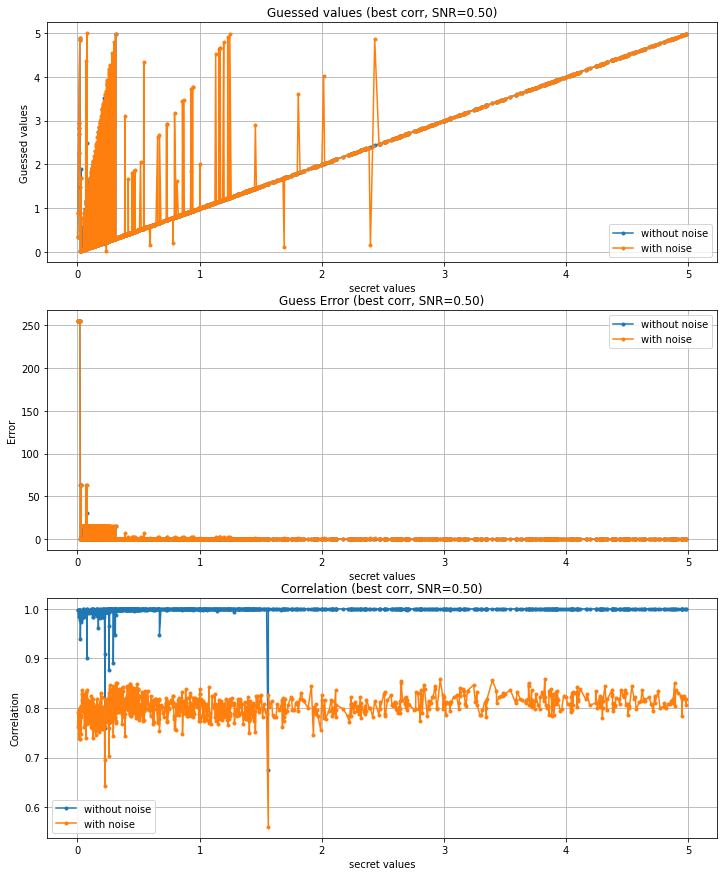

In [36]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

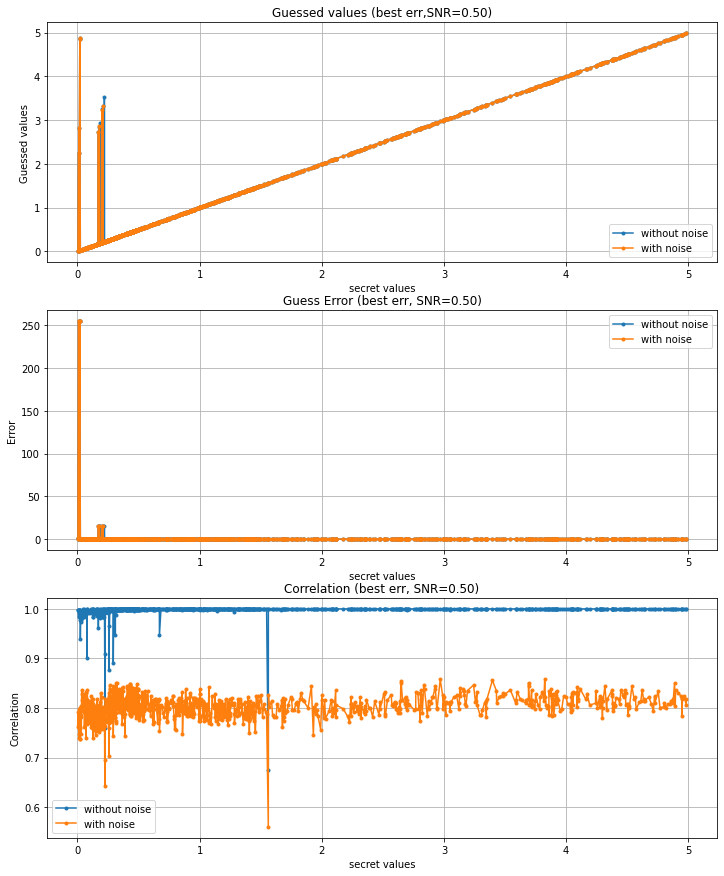

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

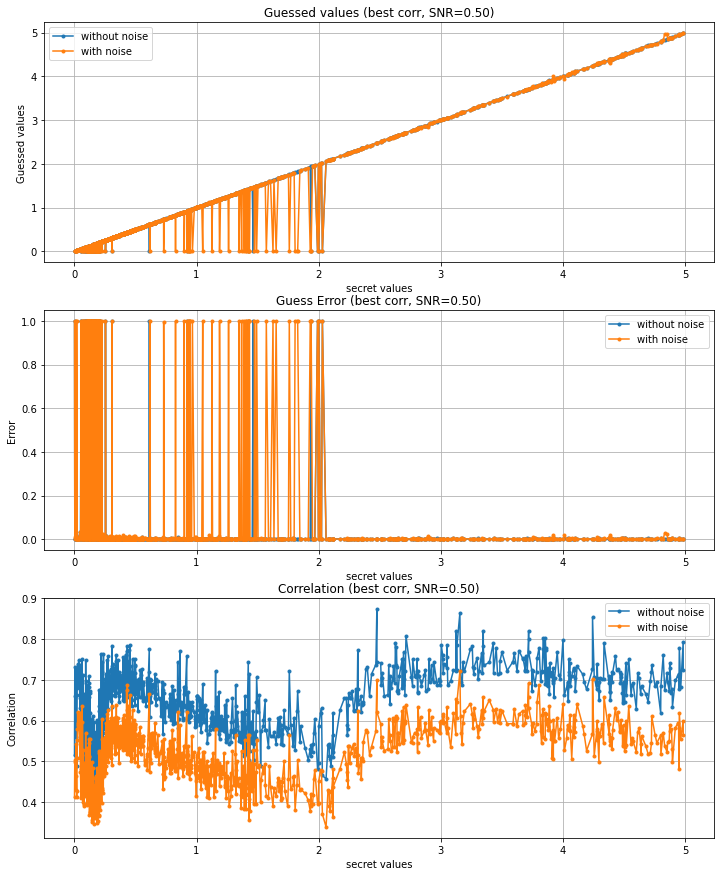

In [38]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [68]:
TEST_NAME='test-name'

batina_results.to_csv('batina_results.csv')
noise_batina_results.to_csv('noise_batina_results.csv')
results.to_csv('results.csv')
noise_results.to_csv('noise_results.csv')